# Business Cases for Data Science


## Business Case 3 - Instacart Market Basket Analysis <img src="./logo.png" alt="Logo" style="width: 150px;"/>
### Group AA
**Members**:
- Emil Ahmadov (m20201004@novaims.unl.pt)
- Doris Macean (m20200609@novaims.unl.pt)
- Doyun Shin (m20200565@novaims.unl.pt)
- Anastasiia Tagiltseva (m20200041@novaims.unl.pt)



<a class="anchor" id="0.1"></a>

# **Table of Contents**

1. [Business Understanding](#1)

2. [Data Understanding](#2)
  
3. [Data Preparation](#3)

4. [Clustering](#4)
   
5. [Modeling](#5)
   
6. [Analysis per day of week](#5)

7. [Evaluation](#7)
 
8. [Deployment](#8)

# **1. Business Understanding** <a class="anchor" id="1"></a>

Company wants to see overview of Instacart's business: 

- What are the main types of consumer behavior in the business?
- Which types of products should have an extended amount of product offerings?
- Which types of products can be seen as substitutes?
- Which items are complementary?

#### Project Plan
| Phase | Time | Resources | Risks |
| :--: | :--------: |:--: | :--------: |
| Business Understanding | 1 day | All analysts | Economic and market changes |
| Data Understanding | 1 day | All analysts | Data problems, technological problems |
| Data Preparation | 2 days | Data scientists, DB engineers | Data problems, technological problems |
| Modeling |1 day | Data scientists | Technological problems, inability to build adequate model |
| Evaluation | 1 day | All analysts | Economic change inability to implement results |
| Deployment | 1 day | Data scientists, DB engineers, implementation team | Economic change inability to implement results |

# **2. Data Understanding** <a class="anchor" id="2"></a>

### Datasets description

departments.csv

- **department_id**: numeric - ID of the department
- **department**: categorical - department name

order_products.csv

- **order_id**: numeric - ID of the order
- **product_id**: numeric - ID of the product
- **add_to_cart_order**: numeric - the sequence in which the product is added to the cart in the order  
- **reordered**: numeric - indicates that the customer has a previous order that contains the product  

orders.csv

- **order_id**: numeric - ID of the order
- **user_id**: numeric - ID of the customer
- **order_number**: numeric - number of the order
- **order_dow**: numeric - the day of week
- **order_hour_of_day**: numeric - the hour of the day
- **days_since_prior_order**: numeric - how many days have passed since prior order

products.csv

- **product_id**: numeric - ID of the product
- **department_id**: numeric - ID of the department
- **product_name**: categorical - product name


## 2.1 Exploratory Data Analysis

In [1]:
# Data Processing
import numpy as np 
import pandas as pd 

# Apriori & Recommendation
import mlxtend as ml
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics.pairwise import cosine_similarity

#Visualization & Clustering
import seaborn as sns
color = sns.color_palette()
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
import networkx as nx
import plotly.express as px
from sklearn.cluster import KMeans, AgglomerativeClustering
import plotly.graph_objs as go


# Utilities and others
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(nx.__version__)
print(matplotlib.__version__)
print(np.__version__)

2.4
3.2.2
1.18.5


In [3]:
# read a csv files from current directory into DataFrame and save it to a variables
orders = pd.read_csv(os.path.join(os.getcwd(),'orders.csv'))
products = pd.read_csv(os.path.join(os.getcwd(),'products.csv'))
order_products = pd.read_csv(os.path.join(os.getcwd(),'order_products.csv'))
departments = pd.read_csv(os.path.join(os.getcwd(),'departments.csv'))

In [4]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products.order_id))
products_Unique = len(set(order_products.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))
#customers
print("Number of unique customers in the whole dataset : ",len(set(orders.user_id)))

There are 200000 orders for 134 products
Number of unique customers in the whole dataset :  105273


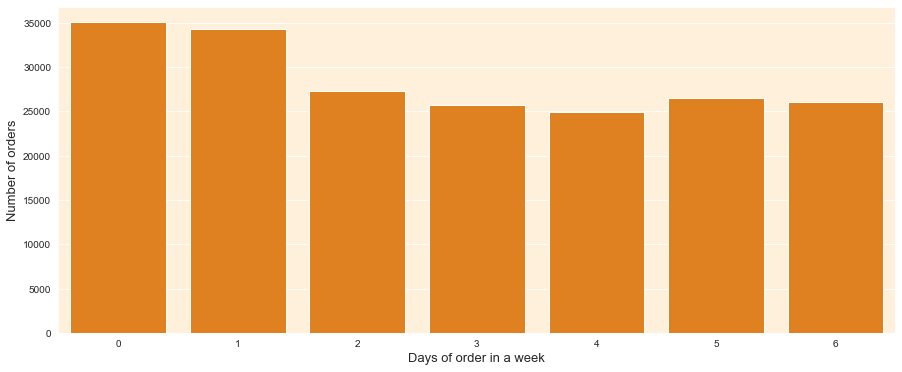

In [5]:
#Days of Orders in a week
grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(grouped.index, grouped.values, color = '#ff8200')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
ax.set_facecolor('#fff0db')
plt.show()

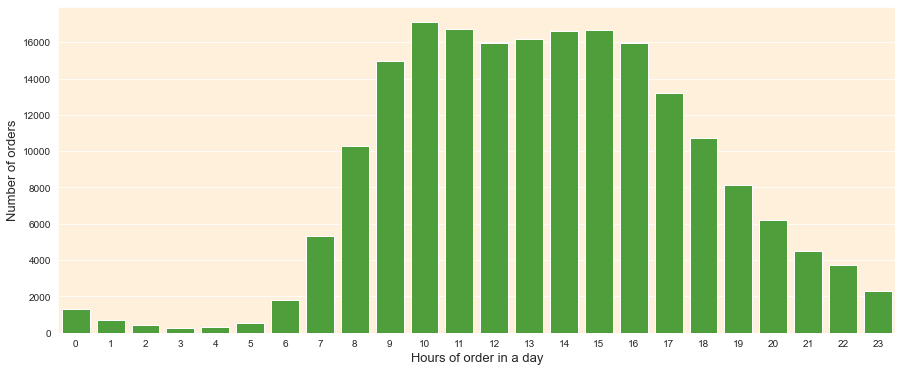

In [6]:
#Hours of Order in a Day
grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(grouped.index, grouped.values, color = '#43b02a')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
ax.set_facecolor('#fff0db')
plt.show()

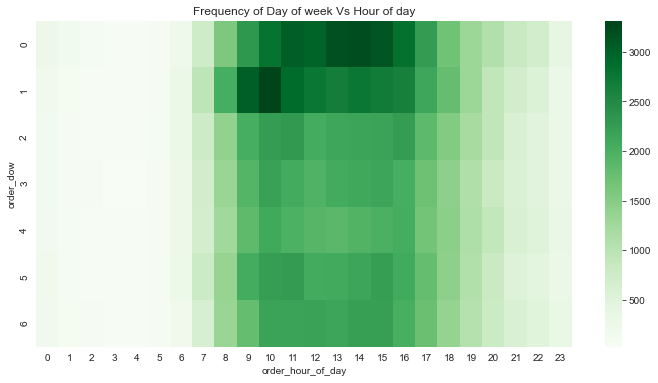

In [7]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="Greens")
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

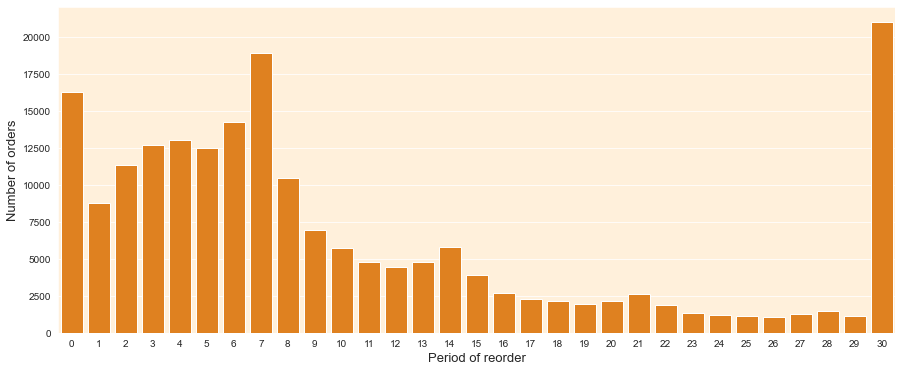

In [8]:
#Period of Reorders
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(grouped.index, grouped.values, color = '#ff8200')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
ax.set_facecolor('#fff0db')
plt.show()

# The chart indicates Weekly and Monthly orders are the most popular.

In [9]:
#Do people usually reorder the same previous ordered products ?
grouped = order_products.groupby("reordered")["product_id"].agg(Total = 'count').reset_index()
grouped['Ratios'] = round(grouped["Total"].apply(lambda x: x /grouped["Total"].sum())*100,2)
grouped
#59 % of ordered products are previously ordered by customers

reordered    Total  Ratios
0          0   828515   41.03
1          1  1190986   58.97

Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered. Let us check that now.

In [10]:
grouped_df = order_products.groupby("order_id")["reordered"].agg("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.88172
0    0.11828
Name: reordered, dtype: float64

About 12% of the orders has no re-ordered items

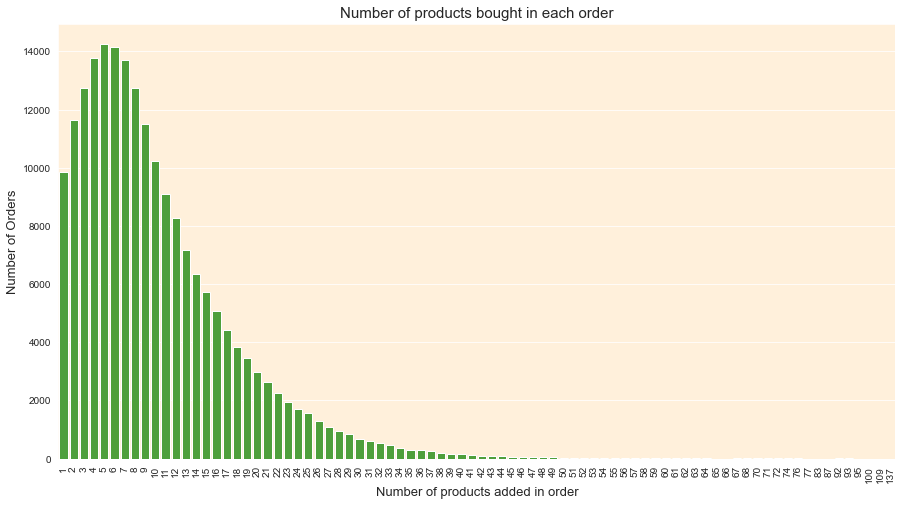

In [11]:
grouped = order_products.groupby("order_id")["add_to_cart_order"].agg("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color = '#43b02a')
plt.title("Number of products bought in each order", fontsize=15)
ax.set_facecolor('#fff0db')

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

A right tailed distribution with the maximum value at 5

In [12]:
# Rank the top 10 best-selling items
grouped = order_products.groupby("product_id")["reordered"].agg(frequency_count = 'count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
percent = grouped.product_name.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
grouped = grouped.sort_values(by= 'frequency_count', ascending=False)[:10]
grouped[['product_name','frequency_count']].reset_index(drop=True)

product_name  frequency_count
0                   fresh fruits           226039
1               fresh vegetables           212611
2     packaged vegetables fruits           109596
3                         yogurt            90751
4                packaged cheese            61502
5                           milk            55150
6  water seltzer sparkling water            52564
7                 chips pretzels            45306
8                soy lactosefree            39389
9                          bread            36381

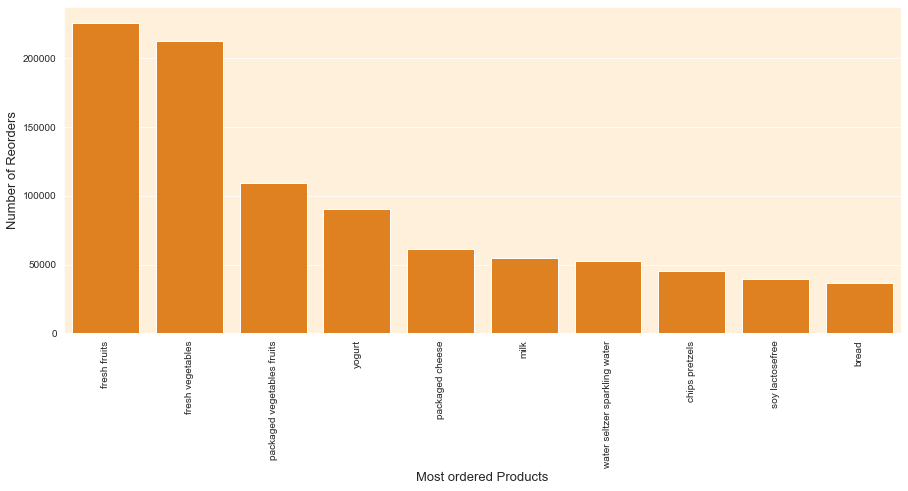

In [13]:
grouped  = grouped.groupby(['product_name']).sum()['frequency_count'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color = '#ff8200')
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
ax.set_facecolor('#fff0db')
plt.show()

In [14]:
#Which products are usually reordered
grouped = order_products.groupby("product_id")["reordered"].agg(reorder_sum = 'sum', reorder_total = 'count').reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

product_id  reorder_sum  reorder_total  reorder_probability  \
83           84        43162          55150             0.782629   
114         115        38467          52564             0.731813   
23           24       162355         226039             0.718261   
85           86        19798          27986             0.707425   
90           91        27251          39389             0.691843   
31           32        12021          17408             0.690545   
52           53        13625          19786             0.688618   
119         120        62464          90751             0.688301   
111         112        24540          36381             0.674528   
30           31        23854          35893             0.664586   

                      product_name  
83                            milk  
114  water seltzer sparkling water  
23                    fresh fruits  
85                            eggs  
90                 soy lactosefree  
31                packaged produce  
52                           cream  
119                         yogurt  
111                          bread  
30                    refrigerated

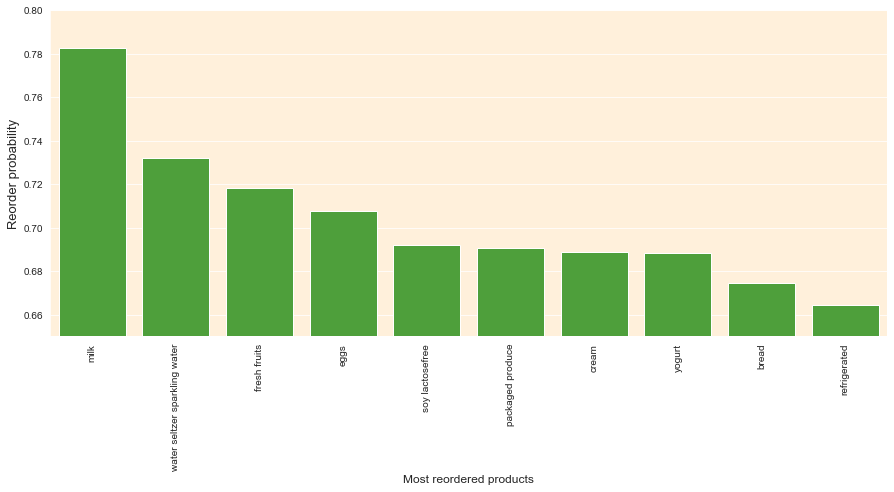

In [15]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color = '#43b02a')
plt.ylim([0.65,0.80])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
ax.set_facecolor('#fff0db')
plt.show()

In [16]:
#obtaining user, order and product detailed info for prior set
user_order_products=pd.merge(orders,order_products, on='order_id',how='left')
user_order_products_all_details=pd.merge(user_order_products,products,on='product_id',how='left')

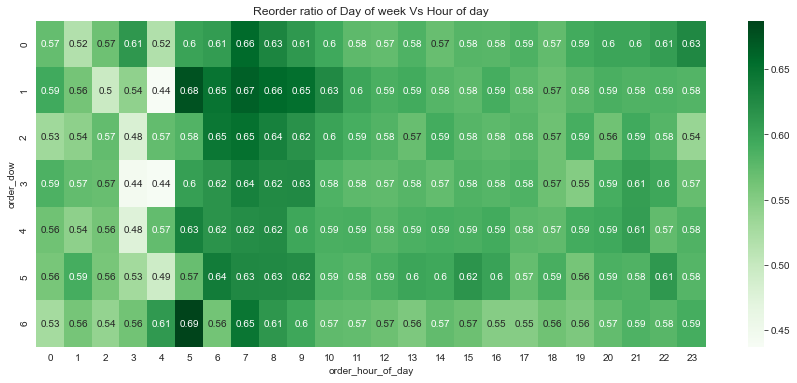

In [17]:
#extracting order_dow_hod_reord_count, the number of reorders for a particular day of the week and particular hour of the day
order_dow_hod_reord_count=user_order_products_all_details.groupby(['order_dow','order_hour_of_day']).agg({'reordered':sum}).reset_index()
order_dow_hod_reord_count.columns=['order_dow','order_hour_of_day','order_dow_hod_reord_count']

#extracting order_dow_hod_reord_prop, the proportion of reorders for a particular day of the week and particular hour of the day
order_dow_hod_reord_prop=pd.DataFrame(order_dow_hod_reord_count)
order_dow_hod_reord_prop['order_dow_hod_reord_cnt']=user_order_products_all_details.groupby(['order_dow','order_hour_of_day']).agg({'reordered':'count'}).reset_index().reordered
order_dow_hod_reord_prop['order_dow_hod_reord_prop']=order_dow_hod_reord_prop['order_dow_hod_reord_count']/order_dow_hod_reord_prop['order_dow_hod_reord_cnt']
order_dow_hod_reord_prop.drop(['order_dow_hod_reord_count','order_dow_hod_reord_cnt'],axis=1,inplace=True)

#Plotting heatmap illustrating reordering probability in order_dow, order_hour_of_day space
plt.figure(figsize=(15,6))
sns.heatmap(order_dow_hod_reord_count.pivot('order_dow','order_hour_of_day','order_dow_hod_reord_prop'),annot=True,cmap="Greens")
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

From the above plot, we can observe that probability of reordering is more on 6st day of the week 5th hour of day, followed by 1st day of week 5th hour of day

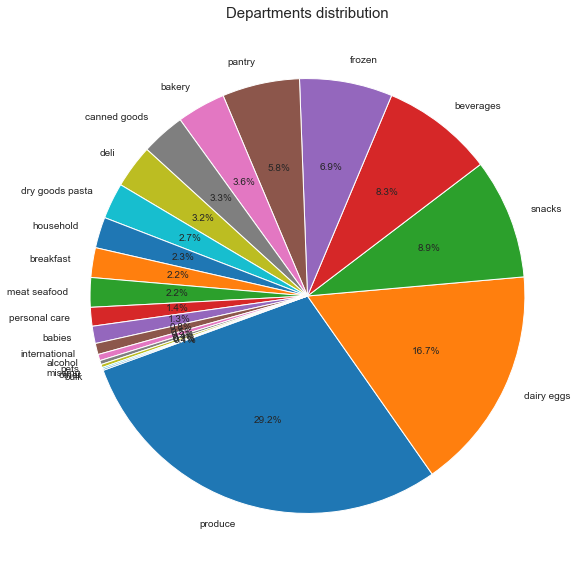

In [18]:
# products bought distribution by department
combdf = pd.merge(order_products,products, on="product_id")
combdf = pd.merge(combdf,departments, on ='department_id')

plt.figure(figsize=(10,10))
temp_series = combdf['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

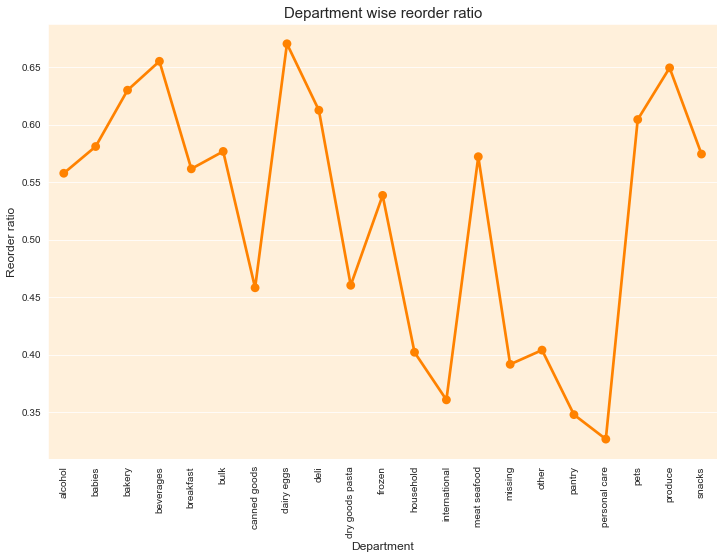

In [19]:
#reorder ratio by department
grouped_df = combdf.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8,color='#ff8200')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

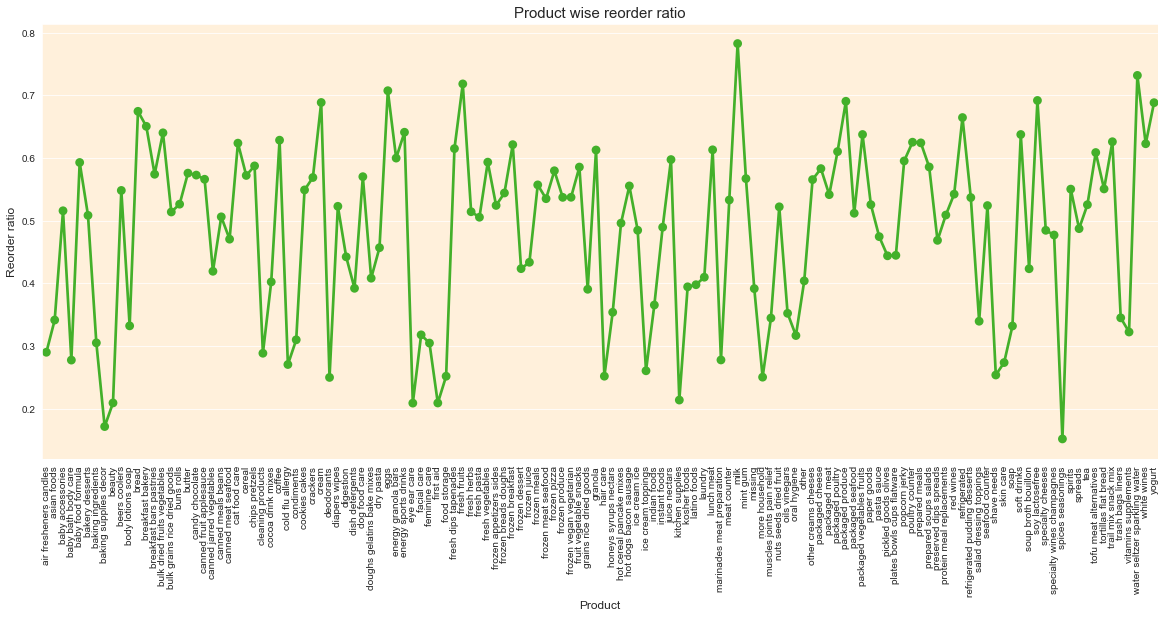

In [20]:
grouped_df = combdf.groupby(["product_name"])["reordered"].aggregate("mean").reset_index()
grouped_df

plt.figure(figsize=(20,8))
sns.pointplot(grouped_df['product_name'].values, grouped_df['reordered'].values, alpha=0.8, color = '#43b02a')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.title("Product wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

#values with low reorder rate are likely to be one-shot purchases for a lot of customers

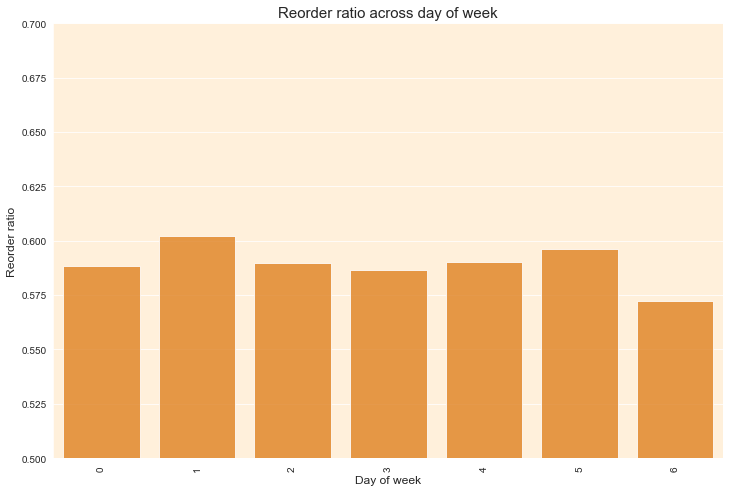

In [21]:
grouped_df = user_order_products_all_details.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color ='#ff8200')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

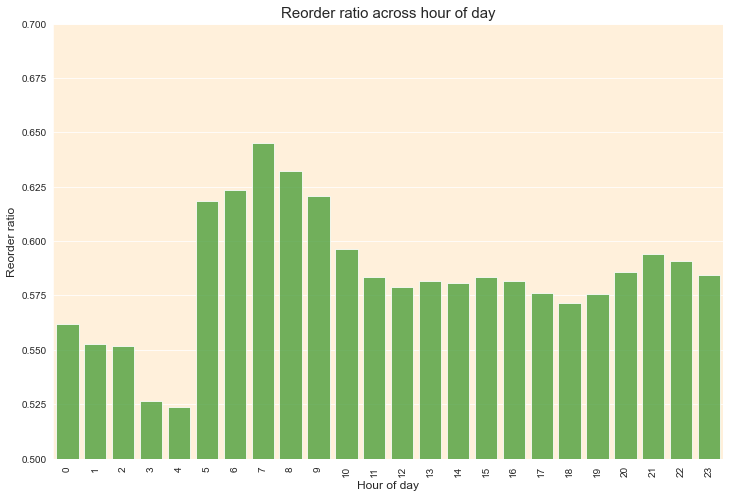

In [22]:
grouped_df = user_order_products_all_details.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color = '#43b02a')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

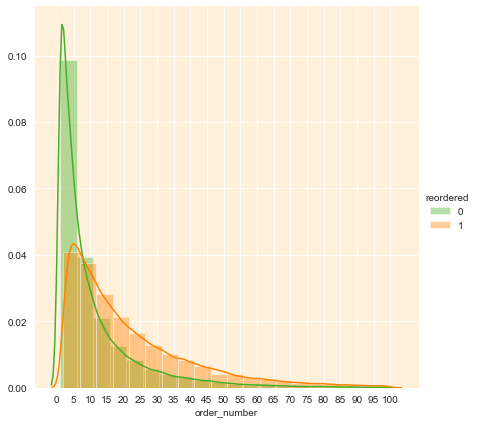

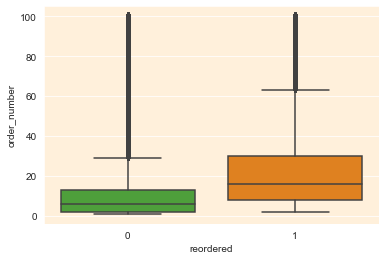

In [23]:
#plotting pdf of order_number
my_pal = {"#ff8200",'#43b02a'}
sns.FacetGrid(user_order_products_all_details,hue='reordered',height=6, palette=my_pal).map(sns.distplot,'order_number',bins=20)\
.set(xticks=range(0,101,5))\
.add_legend()
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

#plotting boxplot of order_number
sns.boxplot(x='reordered',y='order_number',data=user_order_products_all_details, palette=my_pal)
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

From the above plot, we can observe that when the order number is less than 10 the non-reordered class dominates and when order number is greater than 10, the reordered class starts to dominate.

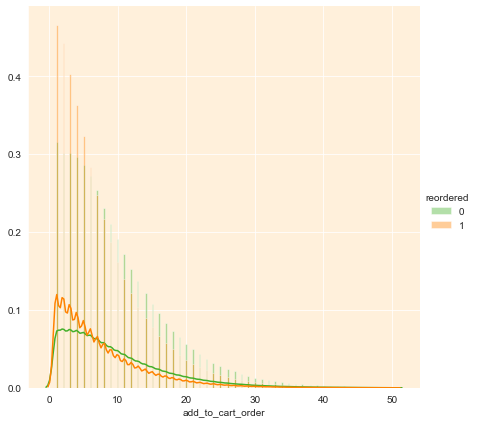

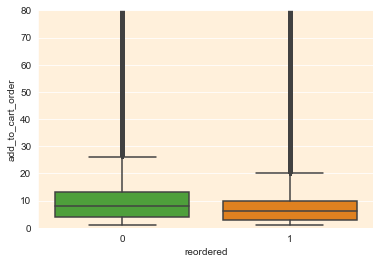

In [24]:
#plotting PDF of first 50 add_to_cart_order for better view
my_pal = {"#ff8200",'#43b02a'}
sns.FacetGrid(user_order_products_all_details[user_order_products_all_details.add_to_cart_order<=50],hue='reordered',height=6,palette=my_pal)\
.map(sns.distplot,'add_to_cart_order',bins=200)\
.add_legend()
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

#plotting boxplot of add_to_cart_order
sns.boxplot(x='reordered',y='add_to_cart_order',data=user_order_products_all_details,palette=my_pal).set(ylim=(0,80))
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

From the above plot we can observe that when add_to_cart_order is less than or equal to 5 , the number of reorders dominate while after 5, the number of non-reorders dominate.

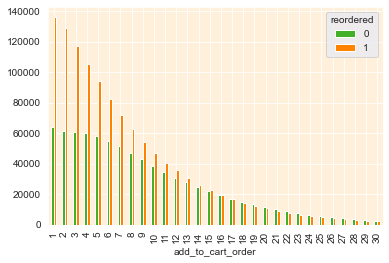

In [25]:
# probability of reordering
my_pal = {"#ff8200",'#43b02a'}
temp = user_order_products_all_details.groupby(['add_to_cart_order','reordered'])
temp=temp.size().unstack()
temp =temp.head(30)
temp.plot(kind = "bar", rot = 90, stacked = False, color=my_pal)
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

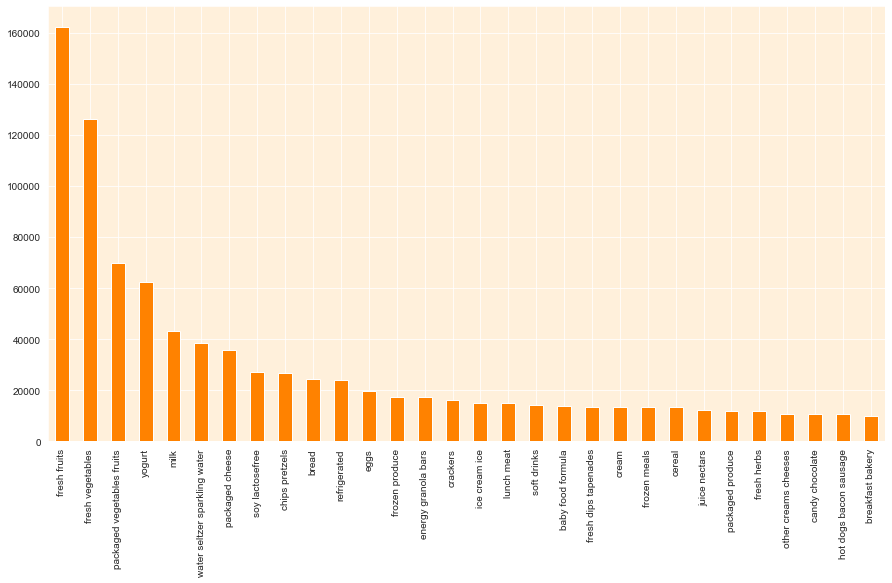

In [26]:
#most reordered product 
temp = user_order_products_all_details[user_order_products_all_details.reordered == 1]
temp = temp.product_name.value_counts()
temp = temp.head(30)
plt.figure(figsize=(15,8))
temp.plot(kind = "bar", rot = 90, stacked = False, color='#ff8200')
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

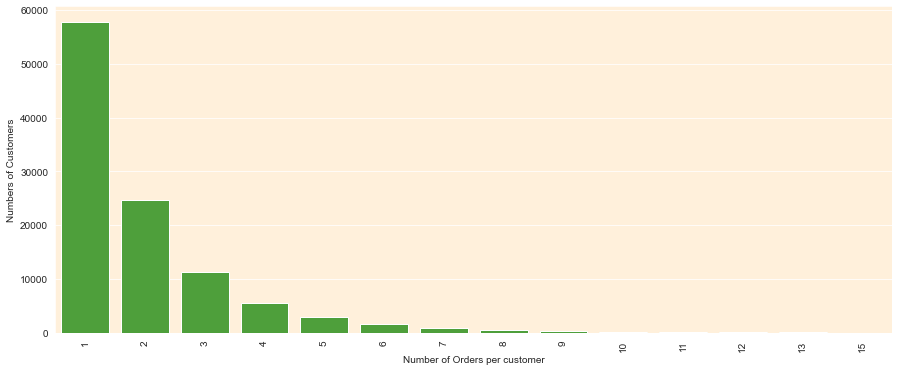

In [27]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15, 6))
ax.set_facecolor('#fff0db')
sns.barplot(grouped.index, grouped.user_id, color = '#43b02a')
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

In [28]:
items  = pd.merge(left=products, right=departments, how='left')
grouped = items.groupby("department")["product_id"].agg(Total_products = 'count').reset_index()
grouped['Ratio'] = round(grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())*100,2)
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped.reset_index(drop=True)

department  Total_products  Ratio
0     personal care              17  12.69
1            pantry              12   8.96
2            frozen              11   8.21
3            snacks              11   8.21
4        dairy eggs              10   7.46
5         household              10   7.46
6         beverages               8   5.97
7      meat seafood               7   5.22
8           alcohol               5   3.73
9      canned goods               5   3.73
10             deli               5   3.73
11  dry goods pasta               5   3.73
12          produce               5   3.73
13           bakery               5   3.73
14        breakfast               4   2.99
15           babies               4   2.99
16    international               4   2.99
17             bulk               2   1.49
18             pets               2   1.49
19            other               1   0.75
20          missing               1   0.75

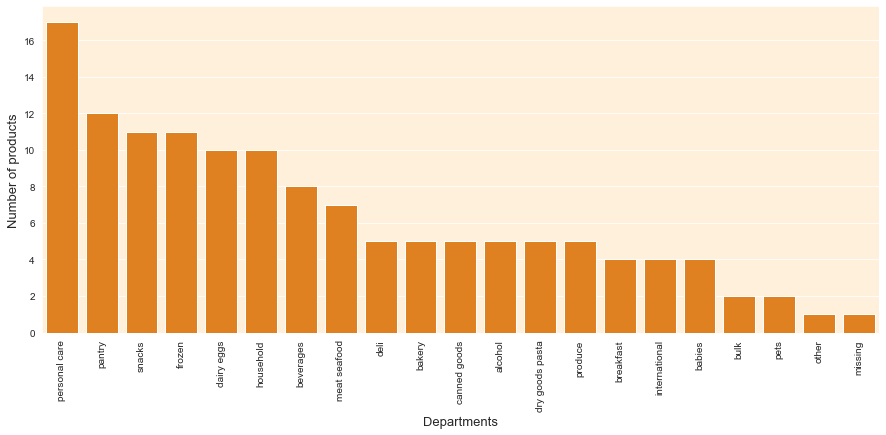

In [29]:
grouped  = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15, 6))
ax.set_facecolor('#fff0db')
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values,color='#ff8200')
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

In [30]:
users_flow = orders[['user_id', 'order_id']].merge(order_products[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

In [31]:
grouped = users_flow.groupby("department")["order_id"].agg( Total_orders = 'count').reset_index()
grouped['Ratio'] = round(grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())*100,2)
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped.reset_index(drop=True)

department  Total_orders  Ratio
0           produce        588996  29.17
1        dairy eggs        336915  16.68
2            snacks        180692   8.95
3         beverages        168126   8.33
4            frozen        139536   6.91
5            pantry        116262   5.76
6            bakery         72983   3.61
7      canned goods         66053   3.27
8              deli         65176   3.23
9   dry goods pasta         54054   2.68
10        household         46446   2.30
11        breakfast         44605   2.21
12     meat seafood         44271   2.19
13    personal care         28134   1.39
14           babies         25940   1.28
15    international         16738   0.83
16          alcohol          9439   0.47
17             pets          6013   0.30
18          missing          4749   0.24
19            other          2240   0.11
20             bulk          2133   0.11

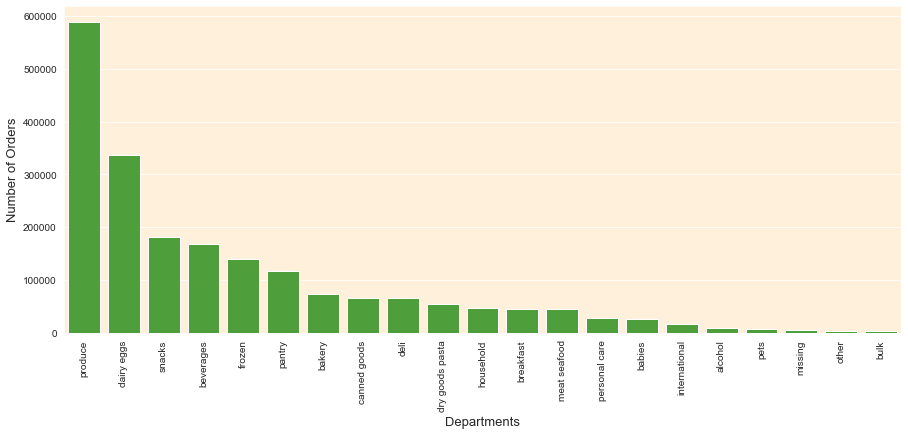

In [32]:
grouped  = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(15, 6))
ax.set_facecolor('#fff0db')
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values,color = '#43b02a')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

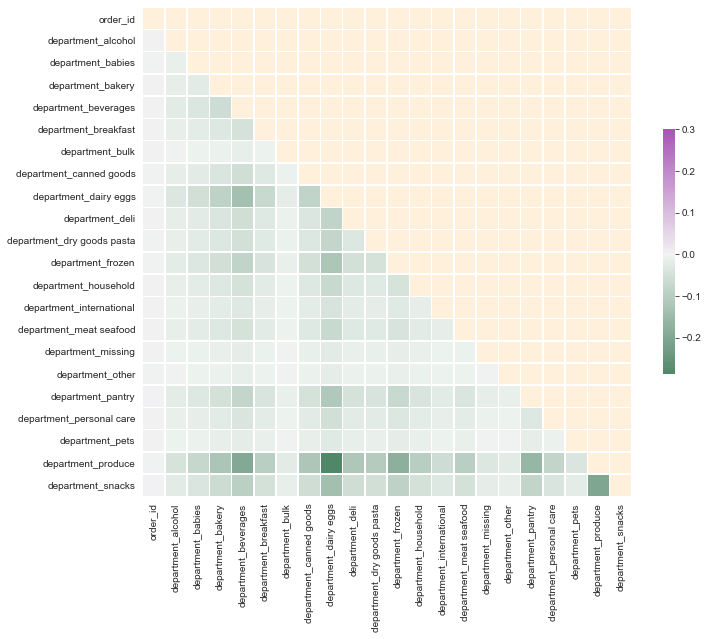

In [33]:
filtered = combdf[['order_id','department']]
ohe_filtered = pd.get_dummies(filtered)

corr = ohe_filtered.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

In [34]:
#top-10 most ordering customers
temp = orders.merge(order_products, on='order_id')
pd.DataFrame(temp.groupby('user_id')['product_id'].count()).sort_values('product_id', ascending=False).head(10)

product_id
user_id            
176478          460
129928          405
126305          384
201268          347
115495          283
100330          271
31903           270
15503           258
105213          245
203166          240

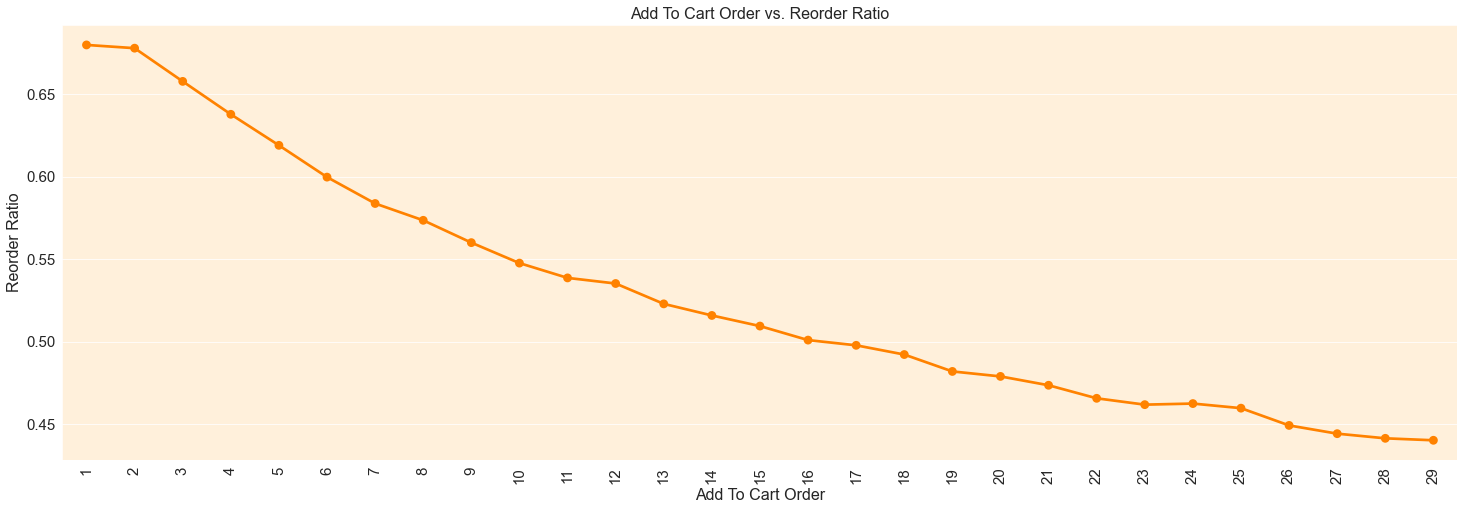

In [35]:
add_to_cart_order_reordered_ratio=order_products[order_products['add_to_cart_order']<30]
add_to_cart_order_reordered_ratio = add_to_cart_order_reordered_ratio.groupby('add_to_cart_order')['reordered'].mean().reset_index()
plt.figure(figsize=(25,8))
sns.pointplot(add_to_cart_order_reordered_ratio.add_to_cart_order, add_to_cart_order_reordered_ratio.reordered, color = '#ff8200' )
plt.title('Add To Cart Order vs. Reorder Ratio', fontsize=16)
plt.xlabel('Add To Cart Order', fontsize=16)
plt.xticks(fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel('Reorder Ratio', fontsize=16)
plt.yticks(fontsize=15);
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

In [36]:
# top 15 first choices
grouped = user_order_products_all_details[user_order_products_all_details['add_to_cart_order'] == 1].groupby(['product_name'])['order_id'].agg(['count']).sort_values(by='count',ascending=False) 
grouped[:15]

count
product_name                        
fresh fruits                   27806
fresh vegetables               14858
milk                           11834
water seltzer sparkling water  10148
packaged vegetables fruits      8663
yogurt                          8284
soy lactosefree                 5734
refrigerated                    4643
packaged cheese                 4163
soft drinks                     3893
bread                           3875
eggs                            3847
chips pretzels                  3423
packaged produce                3178
ice cream ice                   3134

In [37]:
# top 15 second choices
grouped = user_order_products_all_details[user_order_products_all_details['add_to_cart_order'] == 2].groupby(['product_name'])['order_id'].agg(['count']).sort_values(by='count',ascending=False) 
grouped[:15] 

count
product_name                        
fresh fruits                   26382
fresh vegetables               16320
packaged vegetables fruits      9360
yogurt                          8917
milk                            8459
water seltzer sparkling water   7660
soy lactosefree                 5049
packaged cheese                 4567
refrigerated                    4234
bread                           4034
eggs                            3720
chips pretzels                  3553
soft drinks                     3177
packaged produce                3047
ice cream ice                   2850

In [38]:
# groupby product frequency and average position in cart 
user_order_products_all_details.groupby(['product_name'])['add_to_cart_order'].agg(['count','mean']).sort_values(by='count',ascending=False) 

count       mean
product_name                                 
fresh fruits                226039   7.160176
fresh vegetables            212611   8.840718
packaged vegetables fruits  109596   8.452434
yogurt                       90751   7.942381
packaged cheese              61502   9.116256
...                            ...        ...
kitchen supplies               561   8.766488
baby bath body care            515  10.897087
baby accessories               504   9.250000
beauty                         387   9.431525
frozen juice                   279  10.243728

[134 rows x 2 columns]

In [39]:
user_order_products_all_details.groupby(['product_name'])['add_to_cart_order'].agg(['count','mean']).sort_values(by='mean',ascending=True).head(15) 

count      mean
product_name                                   
specialty wines champagnes        614  4.630293
spirits                          1795  4.694150
packaged produce                17408  5.102999
beers coolers                    3002  5.167555
white wines                      1893  5.211833
milk                            55150  5.565204
red wines                        2135  5.680562
water seltzer sparkling water   52564  5.983259
eggs                            27986  6.426356
soft drinks                     22428  6.482745
soy lactosefree                 39389  6.743736
cream                           19786  6.821136
energy sports drinks             6638  7.033745
fresh fruits                   226039  7.160176
coffee                          12823  7.223427

In [40]:
user_order_products_all_details.groupby(['product_name'])['add_to_cart_order'].apply(lambda x: x.mode().iloc[0]).sort_values(ascending=True).head(15) 

product_name
specialty cheeses                1
refrigerated                     1
refrigerated pudding desserts    1
seafood counter                  1
ice cream ice                    1
hot dogs bacon sausage           1
hot cereal pancake mixes         1
honeys syrups nectars            1
white wines                      1
grains rice dried goods          1
juice nectars                    1
shave needs                      1
soap                             1
frozen pizza                     1
frozen meat seafood              1
Name: add_to_cart_order, dtype: int64

In [41]:
grouped = order_products.groupby("product_id")["reordered"].agg(frequency_count = 'count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
percent = grouped.product_name.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
grouped = grouped.sort_values(by= 'frequency_count', ascending=False)
grouped[['product_name','frequency_count']].reset_index(drop=True)

product_name  frequency_count
0                  fresh fruits           226039
1              fresh vegetables           212611
2    packaged vegetables fruits           109596
3                        yogurt            90751
4               packaged cheese            61502
..                          ...              ...
129            kitchen supplies              561
130         baby bath body care              515
131            baby accessories              504
132                      beauty              387
133                frozen juice              279

[134 rows x 2 columns]

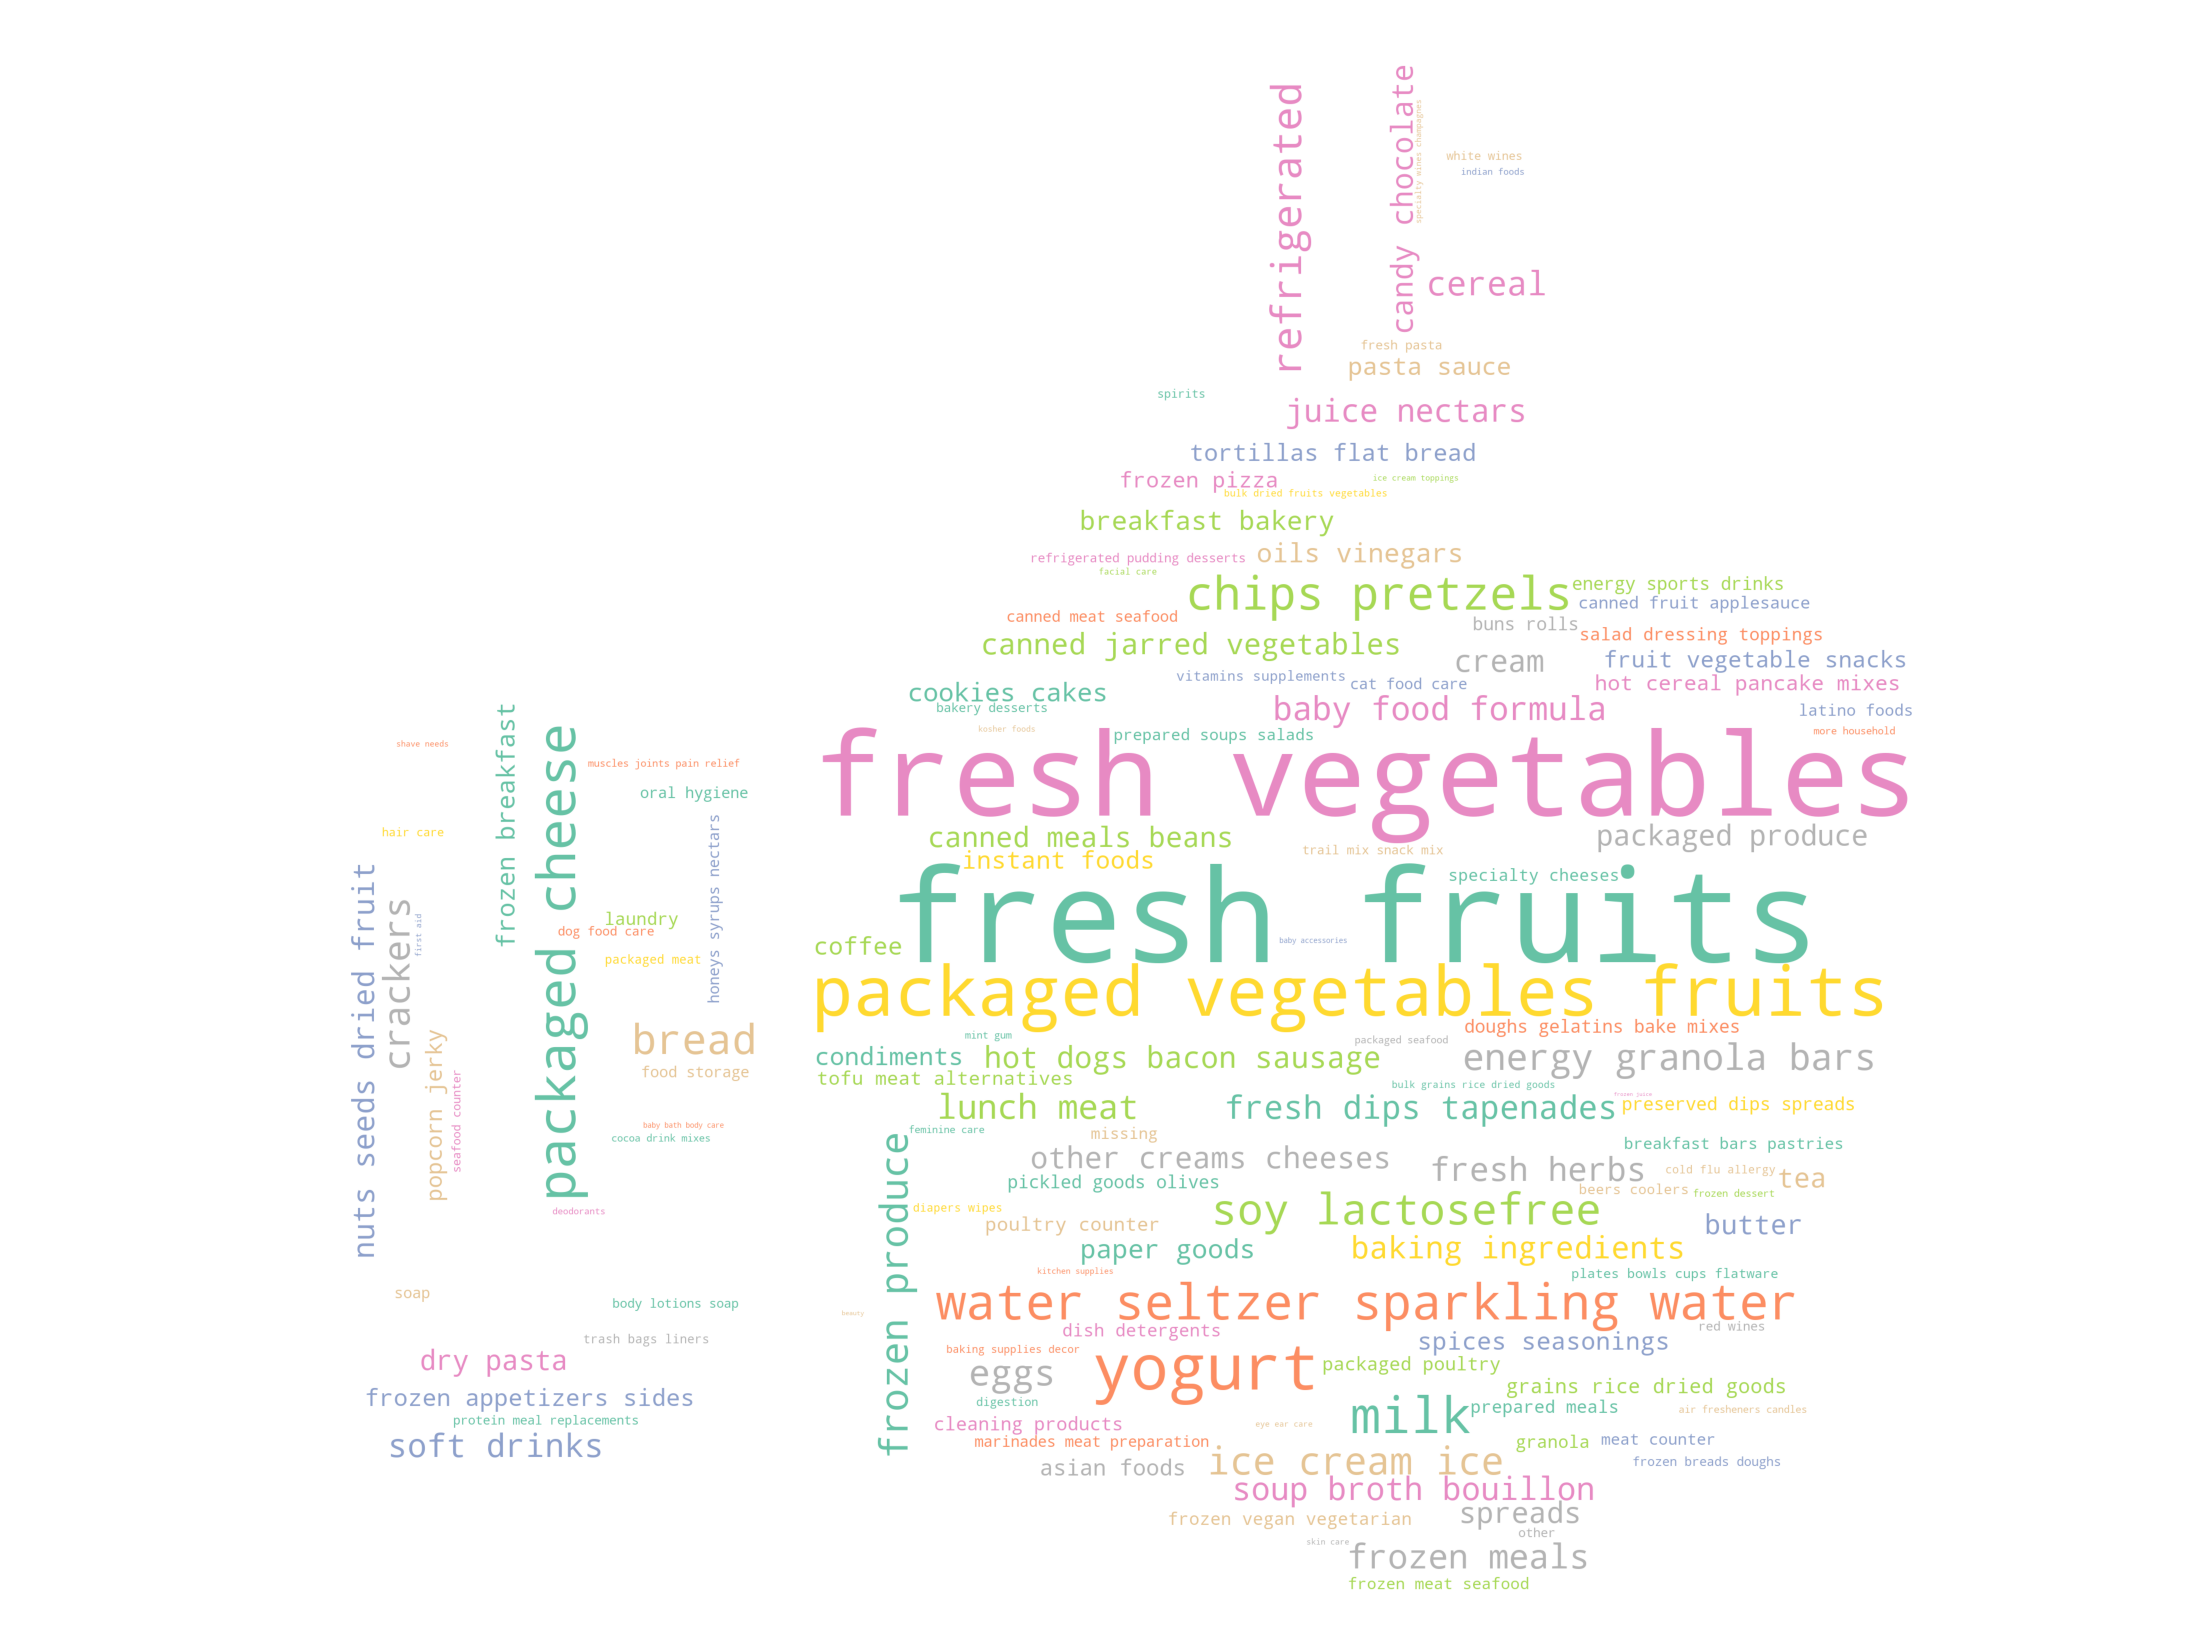

In [42]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
 
 
data = dict(zip(grouped['product_name'].tolist(), grouped['frequency_count'].tolist()))
# Import packages
from wordcloud import WordCloud
from PIL import Image
# Import image to np.array
mask = np.array(Image.open('basket.png'))
# Generate wordcloud
wordcloud = WordCloud(width = 2500, height = 1500, random_state=1, background_color='white', colormap='Set2', collocations=False,  mask=mask).generate_from_frequencies(data)
# Plot
plot_cloud(wordcloud)
 

## 2.2 Data Exploration based on Hours of Day

In [43]:
product_orders_by_hour = pd.DataFrame({'count': temp.groupby(['product_id', 'order_hour_of_day']).size()}).reset_index()
product_orders_by_hour['pct'] = product_orders_by_hour.groupby('product_id')['count'].apply(lambda x: x/x.sum()*100)
mean_hour = pd.DataFrame({'mean_hour': product_orders_by_hour.groupby('product_id').apply(lambda x: sum(x['order_hour_of_day'] * x['count'])/sum(x['count']))}).reset_index()

In [44]:
morning = mean_hour.sort_values('mean_hour')[:15]
morning = morning.merge(products, on='product_id')
morning

product_id  mean_hour  department_id                product_name
0          125  12.878016             19         trail mix snack mix
1           46  12.880901             19                    mint gum
2          111  13.008237             17  plates bowls cups flatware
3          113  13.010753              1                frozen juice
4           94  13.021738              7                         tea
5           53  13.073082             16                       cream
6           11  13.078037             11            cold flu allergy
7           32  13.084674              4            packaged produce
8           29  13.114774             13       honeys syrups nectars
9           26  13.147703              7                      coffee
10           3  13.181291             19         energy granola bars
11          93  13.220811              3            breakfast bakery
12          48  13.227224             14     breakfast bars pastries
13          75  13.232554             17                     laundry
14         109  13.233945             11                   skin care

In [45]:
afternoon = mean_hour.sort_values('mean_hour', ascending=False)[:15]
afternoon = afternoon.merge(products, on='product_id')
afternoon

product_id  mean_hour  department_id                   product_name
0           28  14.125995              5                      red wines
1          132  14.028424             11                         beauty
2           37  13.984133              1                  ice cream ice
3          103  13.919263             19             ice cream toppings
4           62  13.830428              5                    white wines
5          134  13.793160              5     specialty wines champagnes
6          124  13.787187              5                        spirits
7           42  13.756684              1        frozen vegan vegetarian
8           80  13.748918             11                     deodorants
9          119  13.742017              1                 frozen dessert
10          12  13.737607              9                    fresh pasta
11          71  13.735865             16  refrigerated pudding desserts
12          22  13.729178             11                      hair care
13          79  13.684907              1                   frozen pizza
14          20  13.675958             11                   oral hygiene

In [46]:
morning_pct = product_orders_by_hour.merge(morning, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'])
afternoon_pct = product_orders_by_hour.merge(afternoon, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'], ascending=False)

In [47]:
# get list of morning and afteroon product names
morning_product_names = list(morning_pct['product_name'].unique())
morning_product_names = '\n'.join(morning_product_names)
afternoon_product_names = list(afternoon_pct['product_name'].unique())
afternoon_product_names = '\n'.join(afternoon_product_names)

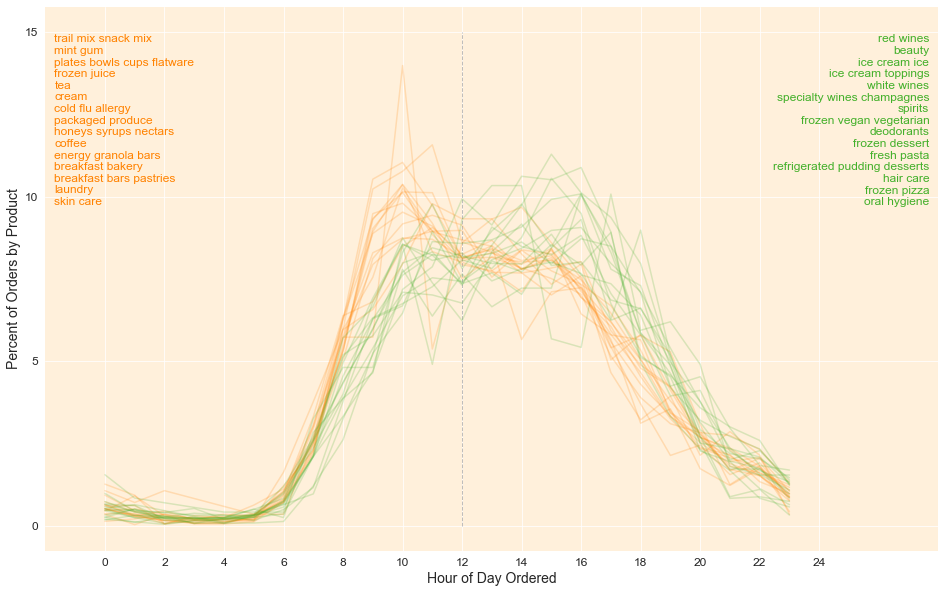

In [48]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 10))

# Plot
morning_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                       y='pct', 
                                       ax=ax, 
                                       legend=False,
                                       alpha=0.2,
                                       aa=True,
                                       color='#ff8200',
                                       linewidth=1.5,)
afternoon_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                         y='pct', 
                                         ax=ax, 
                                         legend=False,
                                         alpha=0.2,
                                         aa=True,
                                         color = '#43b02a',
                                         linewidth=1.5,)

# Aesthetics
# Margins
plt.margins(x=0.5, y=0.05)

# Hide spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Labels
label_font_size = 14
plt.xlabel('Hour of Day Ordered', fontsize=label_font_size)
plt.ylabel('Percent of Orders by Product', fontsize=label_font_size)

# Tick Range
tick_font_size = 12
ax.tick_params(labelsize=tick_font_size)
plt.xticks(range(0, 25, 2))
plt.yticks(range(0, 16, 5))
plt.xlim([-2, 28])

# Vertical line at noon
plt.vlines(x=12, ymin=0, ymax=15, alpha=0.5, color='gray', linestyle='dashed', linewidth=1.0)

# Text
text_font_size = 12
ax.text(0.01, 0.95, morning_product_names,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='#ff8200', fontsize=text_font_size)
ax.text(0.99, 0.95, afternoon_product_names,
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='#43b02a', fontsize=text_font_size);

ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

# **3. Data Preparation** <a class="anchor" id="3"></a>

## **3.1. Handling missing values** <a class="anchor" id="3.1"></a>

In [49]:
total = order_products.isnull().sum().sort_values(ascending=False)
percent = (order_products.isnull().sum()/order_products.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

Total Missing  Percent
reordered                      0      0.0
add_to_cart_order              0      0.0
product_id                     0      0.0
order_id                       0      0.0

In [50]:
all_data = pd.merge(user_order_products_all_details, departments, on='department_id')

In [51]:
all_data.isnull().sum().sort_values(ascending=False)
# they are not missing - it's first order

days_since_prior_order    124342
department                     0
product_name                   0
department_id                  0
reordered                      0
add_to_cart_order              0
product_id                     0
order_hour_of_day              0
order_dow                      0
order_number                   0
user_id                        0
order_id                       0
dtype: int64

# 4. Clusterization <a class="anchor" id="4"></a>

## 4.1 Customer clusterization

In [52]:
order_products_cust = order_products.merge(products, on ='product_id', how='left')
order_products_cust = order_products_cust.merge(departments, on ='department_id', how='left')
order_products_cust = order_products_cust.merge(orders, on='order_id', how='left')
order_products_cust.shape

(2019501, 12)

In [53]:
order_products_cust

order_id  product_id  add_to_cart_order  reordered  department_id  \
0              10          24                  1          1              4   
1              10          83                  2          1              4   
2              10          16                  3          0              4   
3              10          24                  4          1              4   
4              10          83                  5          1              4   
...           ...         ...                ...        ...            ...   
2019496   3420578          66                 17          0              6   
2019497   3420578          16                 18          1              4   
2019498   3420693          37                  1          0              1   
2019499   3420693          37                  2          0              1   
2019500   3420693          37                  3          0              1   

             product_name     department  user_id  order_number  order_dow  \
0            fresh fruits        produce   135442             4          6   
1        fresh vegetables        produce   135442             4          6   
2             fresh herbs        produce   135442             4          6   
3            fresh fruits        produce   135442             4          6   
4        fresh vegetables        produce   135442             4          6   
...                   ...            ...      ...           ...        ...   
2019496       asian foods  international     6586             6          5   
2019497       fresh herbs        produce     6586             6          5   
2019498     ice cream ice         frozen    68287            15          6   
2019499     ice cream ice         frozen    68287            15          6   
2019500     ice cream ice         frozen    68287            15          6   

         order_hour_of_day  days_since_prior_order  
0                        8                     8.0  
1                        8                     8.0  
2                        8                     8.0  
3                        8                     8.0  
4                        8                     8.0  
...                    ...                     ...  
2019496                 21                     5.0  
2019497                 21                     5.0  
2019498                 15                     6.0  
2019499                 15                     6.0  
2019500                 15                     6.0  

[2019501 rows x 12 columns]

In [54]:
#Since there are thousands of products in the dataset we will rely on departmnets, which represent categories of products
cross_df = pd.crosstab(order_products_cust.user_id, order_products_cust.product_name)

In [55]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

product_name  air fresheners candles  asian foods  baby accessories  \
user_id                                                               
2                                0.0          0.0               0.0   
3                                0.0          0.0               0.0   
7                                0.0          0.0               0.0   
10                               0.0          0.0               0.0   
11                               0.0          0.0               0.0   

product_name  baby bath body care  baby food formula  bakery desserts  \
user_id                                                                 
2                             0.0                0.0              0.0   
3                             0.0                0.0              0.0   
7                             0.0                0.0              0.0   
10                            0.0                0.0              0.0   
11                            0.0                0.0              0.0   

product_name  baking ingredients  baking supplies decor  beauty  \
user_id                                                           
2                       0.000000                    0.0     0.0   
3                       0.000000                    0.0     0.0   
7                       0.000000                    0.0     0.0   
10                      0.000000                    0.0     0.0   
11                      0.181818                    0.0     0.0   

product_name  beers coolers  ...   spreads  tea  tofu meat alternatives  \
user_id                      ...                                          
2                       0.0  ...  0.000000  0.0                     0.0   
3                       0.0  ...  0.052632  0.0                     0.0   
7                       0.0  ...  0.000000  0.0                     0.0   
10                      0.0  ...  0.000000  0.0                     0.0   
11                      0.0  ...  0.090909  0.0                     0.0   

product_name  tortillas flat bread  trail mix snack mix  trash bags liners  \
user_id                                                                      
2                              0.0                  0.0                0.0   
3                              0.0                  0.0                0.0   
7                              0.0                  0.0                0.0   
10                             0.0                  0.0                0.0   
11                             0.0                  0.0                0.0   

product_name  vitamins supplements  water seltzer sparkling water  \
user_id                                                             
2                              0.0                       0.000000   
3                              0.0                       0.052632   
7                              0.0                       0.000000   
10                             0.0                       0.000000   
11                             0.0                       0.181818   

product_name  white wines    yogurt  
user_id                              
2                     0.0  0.000000  
3                     0.0  0.000000  
7                     0.0  0.041667  
10                    0.0  0.033333  
11                    0.0  0.000000  

[5 rows x 134 columns]

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

0         1         2         3         4         5         6  \
0  0.086824 -0.161613 -0.028145 -0.013098 -0.060567 -0.048852 -0.038981   
1  0.003981 -0.097846  0.003631 -0.058409  0.099320 -0.056592 -0.017370   
2 -0.082569 -0.005921 -0.055186  0.018264 -0.035471 -0.022070 -0.033966   
3 -0.006792  0.048308 -0.038930 -0.019818  0.052440 -0.018732 -0.017905   
4 -0.166932 -0.034989  0.111684 -0.089721  0.038518  0.045651 -0.014763   

          7         8         9  
0 -0.063232  0.141283  0.050076  
1 -0.030137 -0.005112  0.024813  
2 -0.055984 -0.037421 -0.097942  
3 -0.025402  0.094610  0.048761  
4  0.064996  0.005390 -0.003398

In [57]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

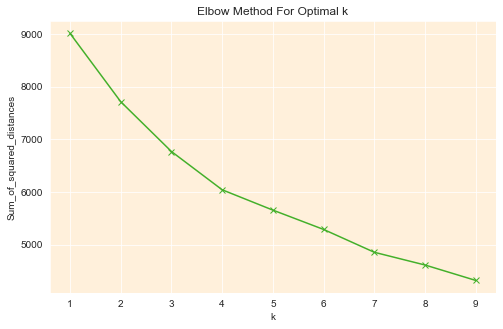

In [58]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-', color= '#43b02a')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

In [59]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 1.02997538e-01  1.57245318e-01  2.27659443e-02  2.74411077e-03
  -1.61522757e-03  1.72446791e-03  1.43429256e-03  3.29399353e-03
  -5.90467967e-04 -1.63177409e-04]
 [-7.32559593e-02 -1.89927467e-02 -3.15222191e-02  6.44243454e-03
   5.94627923e-05 -1.30064229e-02 -2.23372900e-03 -2.76597206e-03
   5.90992576e-04 -6.80426727e-04]
 [-2.37772518e-01 -7.76202390e-02  4.86089708e-01  2.70753754e-02
   3.29216758e-02  7.15082948e-03  1.76759820e-02  6.79626549e-03
   2.09494645e-03  7.53603236e-03]
 [-4.56237644e-03 -9.15046790e-02 -1.86225966e-02 -2.18821142e-01
  -2.89527611e-02  3.35106835e-01  1.10790106e-02  7.96664846e-03
  -8.04724973e-03  4.97011444e-03]
 [ 1.87167535e-01 -1.60007175e-01  1.47249336e-02  7.61817509e-03
   2.66062440e-03 -1.70817278e-02  1.81531630e-03  3.53000346e-03
  -2.69071403e-04  8.84584010e-04]]


In [60]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds

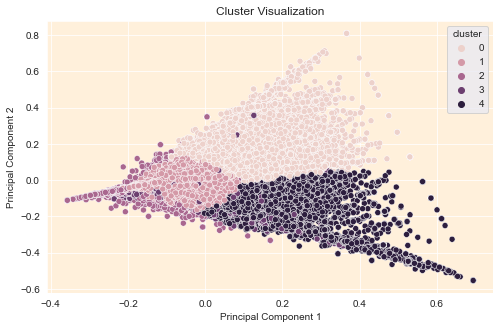

In [61]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

In [62]:
# top products per cluster
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

cluster1.shape

(24508, 135)

In [63]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
fresh vegetables                 5.422964
fresh fruits                     2.708952
packaged vegetables fruits       1.493023
yogurt                           0.714746
packaged cheese                  0.581688
fresh herbs                      0.520891
milk                             0.477354
soy lactosefree                  0.418639
frozen produce                   0.377305
water seltzer sparkling water    0.358006
dtype: float64

In [64]:
cluster2.shape

(61402, 135)

In [65]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
fresh fruits                     1.516172
yogurt                           1.027800
fresh vegetables                 1.026286
packaged vegetables fruits       0.921452
packaged cheese                  0.673757
milk                             0.580339
chips pretzels                   0.566871
water seltzer sparkling water    0.517247
refrigerated                     0.423227
bread                            0.403879
dtype: float64

In [66]:
cluster3.shape

(2530, 135)

In [67]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
water seltzer sparkling water    2.804348
soft drinks                      0.270751
fresh fruits                     0.224506
yogurt                           0.122925
tea                              0.114229
energy granola bars              0.104348
milk                             0.093676
packaged vegetables fruits       0.093281
chips pretzels                   0.090514
coffee                           0.090119
dtype: float64

In [68]:
cluster4.shape

(2912, 135)

In [69]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
packaged produce                 2.910714
fresh fruits                     1.200206
packaged vegetables fruits       0.501717
fresh vegetables                 0.333104
milk                             0.193338
water seltzer sparkling water    0.188874
packaged cheese                  0.167926
frozen produce                   0.132898
nuts seeds dried fruit           0.114698
chips pretzels                   0.112981
dtype: float64

In [70]:
cluster5.shape

(13921, 135)

In [71]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
fresh fruits                     4.488830
fresh vegetables                 1.116946
packaged vegetables fruits       1.058042
yogurt                           0.687882
milk                             0.504059
packaged cheese                  0.375045
soy lactosefree                  0.324689
water seltzer sparkling water    0.314992
bread                            0.245959
frozen produce                   0.239063
dtype: float64

In [72]:
c1 = cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)
c2 = cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)
c3 = cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)
c4 = cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)
c5 = cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)

In [73]:
from IPython.display import display, HTML
cluster_means = [[c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']],
                [c4['fresh fruits'],c4['fresh vegetables'],c4['packaged vegetables fruits'], c4['yogurt'], c4['packaged cheese'], c4['milk'],c4['water seltzer sparkling water'],c4['chips pretzels']],
                [c5['fresh fruits'],c5['fresh vegetables'],c5['packaged vegetables fruits'], c5['yogurt'], c5['packaged cheese'], c5['milk'],c5['water seltzer sparkling water'],c5['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

In [74]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

## 4.2 Product clusterization

In [75]:
#calculate avg
temp = pd.merge(left=products,
         right=order_products.product_id.value_counts().to_frame('count'), 
         left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                    right=pd.DataFrame(order_products.groupby('product_id').reordered.sum().to_frame(), dtype='int64'),  
                    left_index=True, right_index=True)

temp['reorder_rate'] = temp['reordered']/temp['count']

temp = pd.merge(left=temp, 
                right=order_products.groupby('product_id').add_to_cart_order.mean().to_frame('add_to_cart_mean'),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').order_dow.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').order_hour_of_day.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').days_since_prior_order.mean().to_frame(),
                left_index=True, right_index=True)
display(temp.head())
temp.shape

product_id  department_id                product_name  count  reordered  \
1         104             13           spices seasonings   4384       2568   
2          94              7                         tea   5102       2473   
3          38              1                frozen meals  28639      17181   
4           5             13  marinades meat preparation  12651       6194   
5          11             11            cold flu allergy   3836       1066   

   reorder_rate  add_to_cart_mean  order_dow  order_hour_of_day  \
1      0.585766          8.249088   2.988281          13.625000   
2      0.484712          9.302822   2.716263          13.307958   
3      0.599916          9.679633   2.769557          13.516677   
4      0.489606         10.159355   2.706989          13.600806   
5      0.277894         10.288060   2.658768          13.843602   

   days_since_prior_order  
1               11.408333  
2               11.992620  
3               10.973497  
4               10.862661  
5               12.298969

(133, 10)

In [76]:
#Scaling with StandardScaler
temp.drop(['product_name', 'department_id', 'reordered'], axis=1, inplace=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(temp)

In [77]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

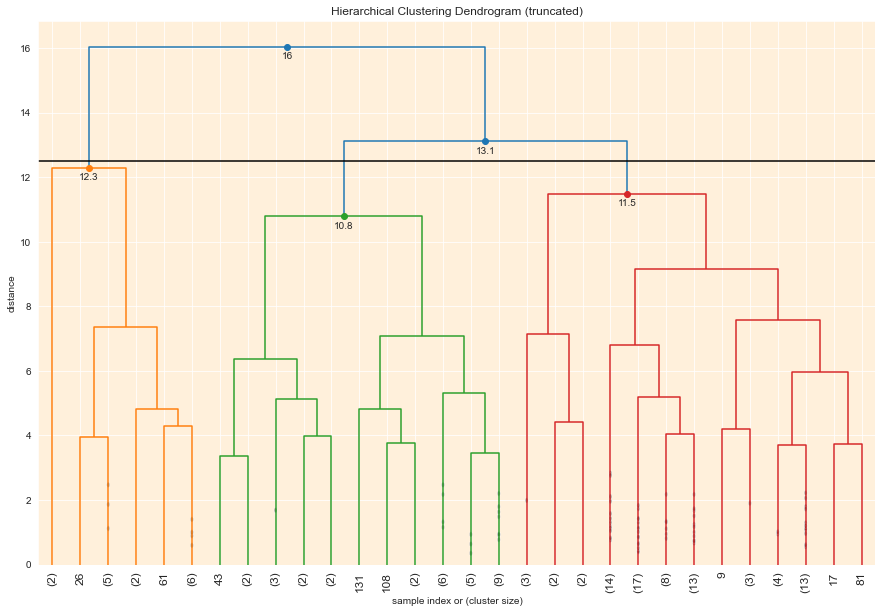

In [78]:
from scipy.cluster.hierarchy import dendrogram, ward

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=12.5
)
ax = plt.gca()
ax.set_facecolor('#fff0db')

plt.show()

In [79]:
from scipy.cluster.hierarchy import fcluster
max_d = 12.5
clusters = fcluster(linked_array, max_d, criterion='distance')
    
labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 17
rr: 65.71

label: 2
n: 34
rr: 36.08

label: 3
n: 82
rr: 49.92


In [80]:
merged_df = pd.DataFrame()
for i in range(1,4):
    test = pd.DataFrame(temp[temp['clusters'] == i].mean())
    test = test.T.set_index('clusters', drop = True)
    test['size'] = temp[temp['clusters'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
merged_df.T.round(2).drop('product_id')

clusters                     1.0      2.0       3.0
count                   56165.12  5570.82  10666.73
reorder_rate                0.66     0.36      0.50
add_to_cart_mean            6.53     9.10      8.98
order_dow                   2.75     2.63      2.80
order_hour_of_day          13.52    13.39     13.53
days_since_prior_order     11.21    11.63     10.73
size                       17.00    34.00     82.00

# **5. Modeling** <a class="anchor" id="5"></a>

In [81]:
df = pd.merge(order_products, products, how='left', on='product_id').drop(["product_id", "department_id","add_to_cart_order", "reordered"], axis=1)

In [82]:
# Define dataset to machine learning
market_basket = pd.pivot_table(df, index='order_id', columns='product_name',aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

market_basket.head()

product_name  air fresheners candles  asian foods  baby accessories  \
order_id                                                              
10                               0.0          0.0               0.0   
11                               0.0          0.0               0.0   
28                               0.0          0.0               0.0   
38                               0.0          0.0               0.0   
56                               0.0          0.0               0.0   

product_name  baby bath body care  baby food formula  bakery desserts  \
order_id                                                                
10                            0.0                1.0              0.0   
11                            0.0                0.0              0.0   
28                            0.0                0.0              0.0   
38                            0.0                0.0              0.0   
56                            0.0                0.0              0.0   

product_name  baking ingredients  baking supplies decor  beauty  \
order_id                                                          
10                           0.0                    0.0     0.0   
11                           0.0                    0.0     0.0   
28                           0.0                    0.0     0.0   
38                           0.0                    0.0     0.0   
56                           0.0                    0.0     0.0   

product_name  beers coolers  ...  spreads  tea  tofu meat alternatives  \
order_id                     ...                                         
10                      0.0  ...      0.0  0.0                     0.0   
11                      0.0  ...      0.0  0.0                     0.0   
28                      0.0  ...      1.0  0.0                     0.0   
38                      0.0  ...      0.0  0.0                     0.0   
56                      0.0  ...      0.0  0.0                     0.0   

product_name  tortillas flat bread  trail mix snack mix  trash bags liners  \
order_id                                                                     
10                             0.0                  0.0                0.0   
11                             0.0                  0.0                0.0   
28                             0.0                  0.0                0.0   
38                             0.0                  0.0                0.0   
56                             0.0                  0.0                0.0   

product_name  vitamins supplements  water seltzer sparkling water  \
order_id                                                            
10                             0.0                            0.0   
11                             0.0                            0.0   
28                             0.0                            0.0   
38                             0.0                            0.0   
56                             0.0                            0.0   

product_name  white wines  yogurt  
order_id                           
10                    0.0     0.0  
11                    0.0     0.0  
28                    0.0     1.0  
38                    0.0     0.0  
56                    0.0     0.0  

[5 rows x 134 columns]

## 5.1 Building the Apriori model <a class="anchor" id="4.1"></a>

**Support**:

refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item divided by total number of transactions

**Confidence**:

refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions where A and B are bought together, divided by total number of transactions where A is bought

**Lift**:

refers to the increase in the ratio of sale of B when A is sold. Lift(A –> B) can be calculated by dividing Confidence(A -> B) divided by Support(B)

**Leverage**:

computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent

**Conviction**:

A high conviction value means that the consequent is highly depending on the antecedent

In [83]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 5%

itemsets = apriori(market_basket, min_support= 0.05, use_colnames=True)

In [84]:
# Build your association rules using the mxltend association_rules function.
# min_threshold can be thought of as the level of confidence percentage that you want to return
# Defined to use 50% of min_threshold

rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [85]:
# Below the list of products sales combinations
# It can use this information to build a cross-sell recommendation system that promotes these products with each other 

rules.sort_values("lift", ascending = False, inplace = True)
rules.head(10)

antecedents  \
160  (packaged vegetables fruits, fresh fruits)   
165                  (yogurt, fresh vegetables)   
40                           (fresh vegetables)   
41                                (fresh herbs)   
163            (fresh fruits, fresh vegetables)   
162        (packaged vegetables fruits, yogurt)   
159    (fresh fruits, fresh vegetables, yogurt)   
166                (packaged vegetables fruits)   
114                        (milk, fresh fruits)   
119                                    (yogurt)   

                                    consequents  antecedent support  \
160                  (yogurt, fresh vegetables)            0.269870   
165  (packaged vegetables fruits, fresh fruits)            0.144660   
40                                (fresh herbs)            0.444360   
41                           (fresh vegetables)            0.093005   
163        (packaged vegetables fruits, yogurt)            0.317560   
162            (fresh fruits, fresh vegetables)            0.127910   
159                (packaged vegetables fruits)            0.118420   
166    (fresh fruits, fresh vegetables, yogurt)            0.365415   
114                                    (yogurt)            0.164310   
119                        (milk, fresh fruits)            0.263675   

     consequent support   support  confidence      lift  leverage  conviction  
160            0.144660  0.076240    0.282506  1.952899  0.037201    1.192122  
165            0.269870  0.076240    0.527029  1.952899  0.037201    1.543710  
40             0.093005  0.078655    0.177007  1.903203  0.037327    1.102069  
41             0.444360  0.078655    0.845707  1.903203  0.037327    3.601205  
163            0.127910  0.076240    0.240081  1.876950  0.035621    1.147609  
162            0.317560  0.076240    0.596044  1.876950  0.035621    1.689392  
159            0.365415  0.076240    0.643810  1.761860  0.032968    1.781592  
166            0.118420  0.076240    0.208639  1.761860  0.032968    1.114006  
114            0.263675  0.074860    0.455602  1.727893  0.031536    1.352550  
119            0.164310  0.074860    0.283910  1.727893  0.031536    1.167018

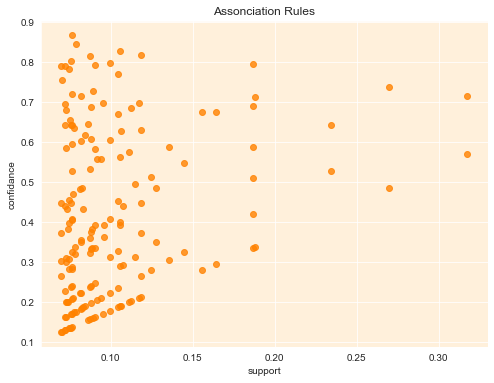

In [86]:
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.figure(figsize=(8,6))    
plt.title('Assonciation Rules')
plt.xlabel('support')
plt.ylabel('confidance')
sns.regplot(x=support, y=confidence, fit_reg=False, color = '#ff8200')
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

In [87]:
# Recommendation of Market Basket
rec_rules = rules[ (rules['lift'] > 1) & (rules['confidence'] >= 0.5) ]

In [88]:
# Recommendation of Market Basket Dataset
cols_keep = {'antecedents':'antecedents', 'consequents':'consequents', 'support':'support', 'confidence':'confidence', 'lift':'lift'}
cols_drop = ['antecedent support', 'consequent support', 'leverage', 'conviction']

recommendation_basket = pd.DataFrame(rec_rules).rename(columns= cols_keep).drop(columns=cols_drop).sort_values(by=['lift'], ascending = False)

display(recommendation_basket)

antecedents  \
165                         (yogurt, fresh vegetables)   
41                                       (fresh herbs)   
162               (packaged vegetables fruits, yogurt)   
159           (fresh fruits, fresh vegetables, yogurt)   
152                         (yogurt, fresh vegetables)   
145                (packaged cheese, fresh vegetables)   
157  (packaged vegetables fruits, fresh fruits, yog...   
144      (packaged cheese, packaged vegetables fruits)   
93                        (packaged vegetables fruits)   
92                    (fresh fruits, fresh vegetables)   
139                           (milk, fresh vegetables)   
121                    (packaged cheese, fresh fruits)   
158  (packaged vegetables fruits, yogurt, fresh veg...   
90          (packaged vegetables fruits, fresh fruits)   
150               (packaged vegetables fruits, yogurt)   
134                             (fresh fruits, yogurt)   
138                 (milk, packaged vegetables fruits)   
84                     (packaged cheese, fresh fruits)   
133               (packaged vegetables fruits, yogurt)   
104                         (yogurt, fresh vegetables)   
108                 (milk, packaged vegetables fruits)   
109                               (milk, fresh fruits)   
72                               (bread, fresh fruits)   
96                     (soy lactosefree, fresh fruits)   
97                 (soy lactosefree, fresh vegetables)   
48                        (packaged vegetables fruits)   
49                                  (fresh vegetables)   
79                            (milk, fresh vegetables)   
91      (packaged vegetables fruits, fresh vegetables)   
42                                    (frozen produce)   
120      (packaged cheese, packaged vegetables fruits)   
127                          (packaged cheese, yogurt)   
73                           (bread, fresh vegetables)   
103                             (fresh fruits, yogurt)   
115                                     (milk, yogurt)   
16                                              (eggs)   
85                 (packaged cheese, fresh vegetables)   
78                                (milk, fresh fruits)   
19                                       (fresh herbs)   
30                        (packaged vegetables fruits)   
46                                   (packaged cheese)   
23                                    (frozen produce)   
20                                      (fresh fruits)   
21                                  (fresh vegetables)   
39                                            (yogurt)   
50                                   (soy lactosefree)   
2                                              (bread)   
14                                              (eggs)   
34                                   (soy lactosefree)   
25                                        (lunch meat)   
54                                            (yogurt)   
0                                              (bread)   
26                                              (milk)   
28                                   (packaged cheese)   
12                                          (crackers)   
32                                      (refrigerated)   
44                                              (milk)   
7                                     (chips pretzels)   
37                     (water seltzer sparkling water)   

                                    consequents   support  confidence  \
165  (packaged vegetables fruits, fresh fruits)  0.076240    0.527029   
41                           (fresh vegetables)  0.078655    0.845707   
162            (fresh fruits, fresh vegetables)  0.076240    0.596044   
159                (packaged vegetables fruits)  0.076240    0.643810   
152                (packaged vegetables fruits)  0.087995    0.608288   
145                (packaged vegetables fruits)  0.081970    0.603386   
157                          (fresh vegetables)  0.

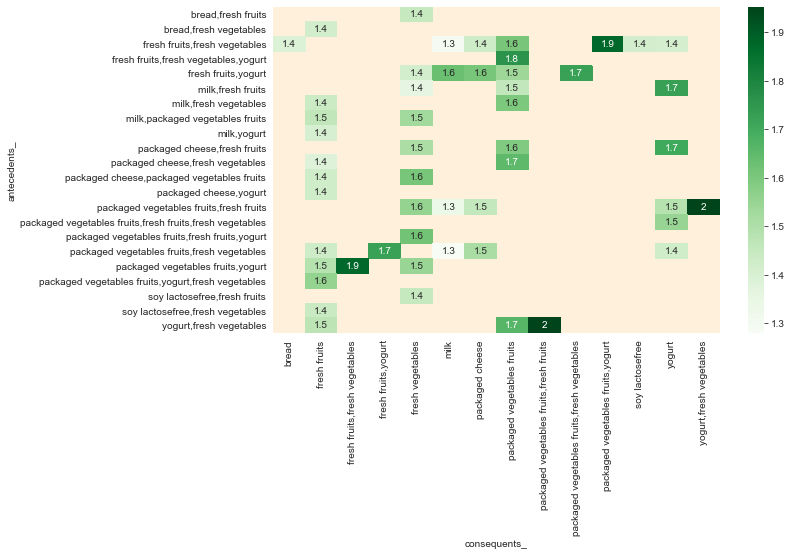

In [89]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x))
# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot = True,cmap="Greens")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

In [90]:
top_rules = rules.sort_values('confidence', ascending = False)[:10]
top_rules

antecedents         consequents  \
158  (packaged vegetables fruits, yogurt, fresh veg...      (fresh fruits)   
41                                       (fresh herbs)  (fresh vegetables)   
133               (packaged vegetables fruits, yogurt)      (fresh fruits)   
104                         (yogurt, fresh vegetables)      (fresh fruits)   
108                 (milk, packaged vegetables fruits)      (fresh fruits)   
97                 (soy lactosefree, fresh vegetables)      (fresh fruits)   
79                            (milk, fresh vegetables)      (fresh fruits)   
91      (packaged vegetables fruits, fresh vegetables)      (fresh fruits)   
120      (packaged cheese, packaged vegetables fruits)      (fresh fruits)   
127                          (packaged cheese, yogurt)      (fresh fruits)   

     antecedent support  consequent support   support  confidence      lift  \
158            0.087995            0.555995  0.076240    0.866413  1.558311   
41             0.093005            0.444360  0.078655    0.845707  1.903203   
133            0.127910            0.555995  0.105790    0.827066  1.487542   
104            0.144660            0.555995  0.118420    0.818609  1.472332   
108            0.107425            0.555995  0.087450    0.814056  1.464143   
97             0.094120            0.555995  0.075620    0.803442  1.445053   
79             0.124715            0.555995  0.099590    0.798541  1.436237   
91             0.234555            0.555995  0.186580    0.795464  1.430703   
120            0.114610            0.555995  0.090715    0.791510  1.423593   
127            0.088520            0.555995  0.070020    0.791008  1.422688   

     leverage  conviction  lhs items  \
158  0.027315    3.323711          3   
41   0.037327    3.601205          1   
133  0.034673    2.567481          2   
104  0.037990    2.447781          2   
108  0.027722    2.387847          2   
97   0.023290    2.258905          2   
79   0.030249    2.203944          2   
91   0.056169    2.170789          2   
120  0.026992    2.129626          2   
127  0.020803    2.124504          2   

                                          antecedents_      consequents_  
158  packaged vegetables fruits,yogurt,fresh vegeta...      fresh fruits  
41                                         fresh herbs  fresh vegetables  
133                  packaged vegetables fruits,yogurt      fresh fruits  
104                            yogurt,fresh vegetables      fresh fruits  
108                    milk,packaged vegetables fruits      fresh fruits  
97                    soy lactosefree,fresh vegetables      fresh fruits  
79                               milk,fresh vegetables      fresh fruits  
91         packaged vegetables fruits,fresh vegetables      fresh fruits  
120         packaged cheese,packaged vegetables fruits      fresh fruits  
127                             packaged cheese,yogurt      fresh fruits

In [91]:
def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
        for c in rules.iloc[i]['consequents']:
                G1.add_nodes_from([c])
                G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                 found_a_string = True
        if found_a_string:
             color_map.append('#ff8200')
        else:
             color_map.append('#43b02a')       
  
  
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
   
    pos = nx.spring_layout(G1, k=16, scale=1, seed=1)
    nx.draw(G1, pos, edgelist =edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
     
    for p in pos:  # raise text positions
             pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    ax = plt.gca()
    ax.set_facecolor('#fff0db')
    plt.show()

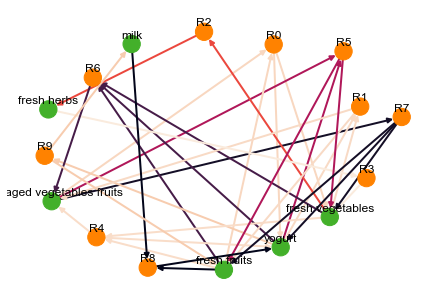

In [92]:
draw_graph (rules, 10)

## 5.2 Substitutes 

### 5.2.1 Frequent itemsets

In [93]:
itemsets

support                                           itemsets
0   0.076635                               (baking ingredients)
1   0.163865                                            (bread)
2   0.074330                                           (butter)
3   0.071890                         (canned jarred vegetables)
4   0.092560                                           (cereal)
..       ...                                                ...
79  0.105790  (packaged vegetables fruits, fresh fruits, yog...
80  0.073075  (milk, packaged vegetables fruits, fresh veget...
81  0.081970  (packaged cheese, packaged vegetables fruits, ...
82  0.087995  (packaged vegetables fruits, yogurt, fresh veg...
83  0.076240  (packaged vegetables fruits, fresh fruits, fre...

[84 rows x 2 columns]

In [94]:
frequent_itemsets=itemsets.copy()

In [95]:
# Reference this cell

### Rules are in the form of "frozensets". Frozensets have functions to check if there are subsets, supersets, etc.
### More info at https://www.journaldev.com/22850/python-frozenset

##### EXPLORE FREQUENT_ITEMSETS #####

# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Length=2 and Support>=0.2
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.1)]

support                                        itemsets  length
33  0.112410                           (bread, fresh fruits)       2
36  0.106300                  (fresh fruits, chips pretzels)       2
43  0.317560                (fresh fruits, fresh vegetables)       2
46  0.164310                            (milk, fresh fruits)       2
47  0.155900                 (packaged cheese, fresh fruits)       2
48  0.269870      (packaged vegetables fruits, fresh fruits)       2
50  0.117480                 (soy lactosefree, fresh fruits)       2
51  0.111045   (fresh fruits, water seltzer sparkling water)       2
52  0.188225                          (fresh fruits, yogurt)       2
55  0.124715                        (milk, fresh vegetables)       2
56  0.135850             (packaged cheese, fresh vegetables)       2
57  0.234555  (packaged vegetables fruits, fresh vegetables)       2
60  0.144660                      (yogurt, fresh vegetables)       2
62  0.107425              (milk, packaged vegetables fruits)       2
64  0.114610   (packaged cheese, packaged vegetables fruits)       2
68  0.127910            (packaged vegetables fruits, yogurt)       2

In [96]:
# Substitute products 
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)

antecedents                      consequents  \
52  (water seltzer sparkling water)               (fresh vegetables)   
53               (fresh vegetables)  (water seltzer sparkling water)   
37  (water seltzer sparkling water)                   (fresh fruits)   
36                   (fresh fruits)  (water seltzer sparkling water)   
69  (water seltzer sparkling water)     (packaged vegetables fruits)   
68     (packaged vegetables fruits)  (water seltzer sparkling water)   
8                (fresh vegetables)                 (chips pretzels)   
9                  (chips pretzels)               (fresh vegetables)   
6                    (fresh fruits)                 (chips pretzels)   
7                  (chips pretzels)                   (fresh fruits)   

    antecedent support  consequent support   support  confidence      lift  \
52            0.193005            0.444360  0.083355    0.431880  0.971915   
53            0.444360            0.193005  0.083355    0.187584  0.971915   
37            0.193005            0.555995  0.111045    0.575348  1.034807   
36            0.555995            0.193005  0.111045    0.199723  1.034807   
69            0.193005            0.365415  0.073715    0.381933  1.045204   
68            0.365415            0.193005  0.073715    0.201730  1.045204   
8             0.444360            0.169435  0.082245    0.185086  1.092374   
9             0.169435            0.444360  0.082245    0.485407  1.092374   
6             0.555995            0.169435  0.106300    0.191189  1.128390   
7             0.169435            0.555995  0.106300    0.627379  1.128390   

    leverage  conviction  
52 -0.002409    0.978033  
53 -0.002409    0.993328  
37  0.003735    1.045573  
36  0.003735    1.008395  
69  0.003188    1.026725  
68  0.003188    1.010929  
8   0.006955    1.019206  
9   0.006955    1.079767  
6   0.012095    1.026896  
7   0.012095    1.191573

In [97]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)

### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]

# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

rulesToPlot

antecedents  \
0                                             (bread)   
1                                             (bread)   
2                                    (chips pretzels)   
3                                          (crackers)   
4                                              (eggs)   
5                                              (eggs)   
6                                       (fresh herbs)   
7                                      (fresh fruits)   
9                                    (frozen produce)   
10                                       (lunch meat)   
11                                             (milk)   
12                                  (packaged cheese)   
13                       (packaged vegetables fruits)   
14                                     (refrigerated)   
15                                  (soy lactosefree)   
16                    (water seltzer sparkling water)   
17                                           (yogurt)   
18                                      (fresh herbs)   
19                                   (frozen produce)   
20                                             (milk)   
21                                  (packaged cheese)   
22                       (packaged vegetables fruits)   
24                                  (soy lactosefree)   
25                                           (yogurt)   
26                              (bread, fresh fruits)   
27                          (bread, fresh vegetables)   
28                               (milk, fresh fruits)   
29                           (milk, fresh vegetables)   
30                    (packaged cheese, fresh fruits)   
31                (packaged cheese, fresh vegetables)   
32         (packaged vegetables fruits, fresh fruits)   
33     (packaged vegetables fruits, fresh vegetables)   
34                   (fresh fruits, fresh vegetables)   
36                    (soy lactosefree, fresh fruits)   
37                (soy lactosefree, fresh vegetables)   
38                             (fresh fruits, yogurt)   
39                         (yogurt, fresh vegetables)   
40                 (milk, packaged vegetables fruits)   
41                               (milk, fresh fruits)   
42                                     (milk, yogurt)   
43      (packaged cheese, packaged vegetables fruits)   
44                    (packaged cheese, fresh fruits)   
45                          (packaged cheese, yogurt)   
46               (packaged vegetables fruits, yogurt)   
47                             (fresh fruits, yogurt)   
48                 (milk, packaged vegetables fruits)   
49                           (milk, fresh vegetables)   
50      (packaged cheese, packaged vegetables fruits)   
51                (packaged cheese, fresh vegetables)   
52               (packaged vegetables fruits, yogurt)   
53                         (yogurt, fresh vegetables)   
54  (packaged vegetables fruits, fresh fruits, yog...   
55  (packaged vegetables fruits, yogurt, fresh veg...   
56           (fresh fruits, fresh vegetables, yogurt)   
57               (packaged vegetables fruits, yogurt)   
58                         (yogurt, fresh vegetables)   

                                   consequents  antecedent support  \
0                               (fresh fruits)            0.163865   
1                           (fresh vegetables)            0.163865   
2                               (fresh fruits)            0.169435   
3                               (fresh fruits)            0.114970   
4                               (fresh fruits)            0.136490   
5                           (fresh vegetables)            0.136490   
6                               (fresh fruits)            0.093005   
7                           (fresh vegetables)            0.555995   
9                               (fresh fruits)            0.122580   
10                              (fresh fruits)            0.103890   
11                    

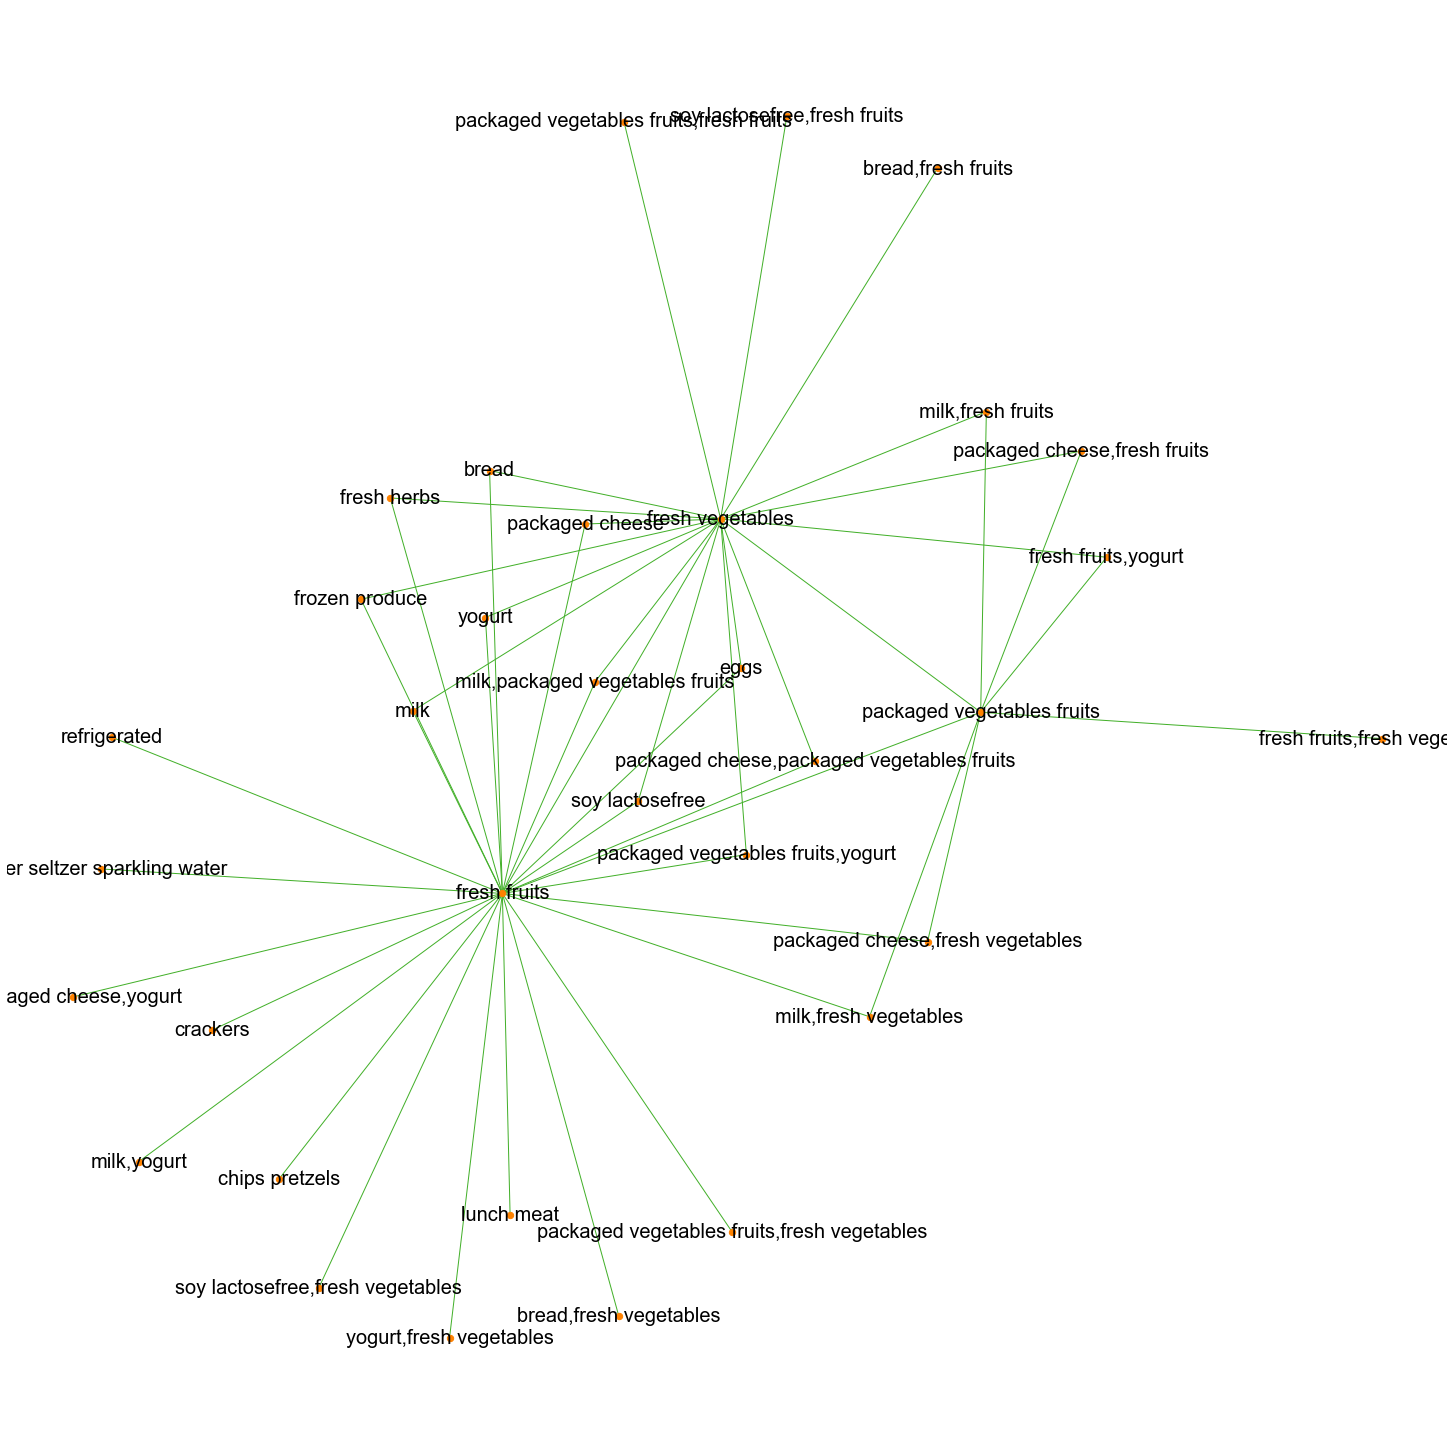

In [98]:
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')

my_pos = nx.spring_layout(G, seed = 1) #for reproducibility 
nx.draw(G, pos=my_pos, with_labels=True, edge_color = '#43b02a', node_size=40, node_color="#ff8200", font_color = 'black', font_size=20)
plt.axis('equal')
plt.show()

In [99]:
# Complement

# High Confidence and high Lift - complementary products
rulesConfidence[(rulesConfidence['confidence'] >= 0.7) & (rulesConfidence['lift'] >= 1.7)]

antecedents         consequents  antecedent support  consequent support  \
18  (fresh herbs)  (fresh vegetables)            0.093005             0.44436   

     support  confidence      lift  leverage  conviction  
18  0.078655    0.845707  1.903203  0.037327    3.601205

In [100]:
# Complement

# High Confidence and high Lift - complementary products
rulesConfidence[(rulesConfidence['confidence'] >= 0.8) & (rulesConfidence['lift'] >= 1.8)]

antecedents         consequents  antecedent support  consequent support  \
18  (fresh herbs)  (fresh vegetables)            0.093005             0.44436   

     support  confidence      lift  leverage  conviction  
18  0.078655    0.845707  1.903203  0.037327    3.601205

In [101]:
# Complement

# High Confidence and high Lift - complementary products
rulesConfidence[(rulesConfidence['confidence'] >= 0.2) & (rulesConfidence['lift'] >= 1)]

antecedents  \
0                                             (bread)   
1                                             (bread)   
2                                    (chips pretzels)   
3                                          (crackers)   
4                                              (eggs)   
5                                              (eggs)   
6                                       (fresh herbs)   
7                                      (fresh fruits)   
8                                  (fresh vegetables)   
9                                    (frozen produce)   
10                                       (lunch meat)   
11                                             (milk)   
12                                  (packaged cheese)   
13                       (packaged vegetables fruits)   
14                                     (refrigerated)   
15                                  (soy lactosefree)   
16                    (water seltzer sparkling water)   
17                                           (yogurt)   
18                                      (fresh herbs)   
19                                   (frozen produce)   
20                                             (milk)   
21                                  (packaged cheese)   
22                       (packaged vegetables fruits)   
23                                 (fresh vegetables)   
24                                  (soy lactosefree)   
25                                           (yogurt)   
26                              (bread, fresh fruits)   
27                          (bread, fresh vegetables)   
28                               (milk, fresh fruits)   
29                           (milk, fresh vegetables)   
30                    (packaged cheese, fresh fruits)   
31                (packaged cheese, fresh vegetables)   
32         (packaged vegetables fruits, fresh fruits)   
33     (packaged vegetables fruits, fresh vegetables)   
34                   (fresh fruits, fresh vegetables)   
35                       (packaged vegetables fruits)   
36                    (soy lactosefree, fresh fruits)   
37                (soy lactosefree, fresh vegetables)   
38                             (fresh fruits, yogurt)   
39                         (yogurt, fresh vegetables)   
40                 (milk, packaged vegetables fruits)   
41                               (milk, fresh fruits)   
42                                     (milk, yogurt)   
43      (packaged cheese, packaged vegetables fruits)   
44                    (packaged cheese, fresh fruits)   
45                          (packaged cheese, yogurt)   
46               (packaged vegetables fruits, yogurt)   
47                             (fresh fruits, yogurt)   
48                 (milk, packaged vegetables fruits)   
49                           (milk, fresh vegetables)   
50      (packaged cheese, packaged vegetables fruits)   
51                (packaged cheese, fresh vegetables)   
52               (packaged vegetables fruits, yogurt)   
53                         (yogurt, fresh vegetables)   
54  (packaged vegetables fruits, fresh fruits, yog...   
55  (packaged vegetables fruits, yogurt, fresh veg...   
56           (fresh fruits, fresh vegetables, yogurt)   
57               (packaged vegetables fruits, yogurt)   
58                         (yogurt, fresh vegetables)   

                                   consequents  antecedent support  \
0                               (fresh fruits)            0.163865   
1                           (fresh vegetables)            0.163865   
2                               (fresh fruits)            0.169435   
3                               (fresh fruits)            0.114970   
4                               (fresh fruits)            0.136490   
5                           (fresh vegetables)            0.136490   
6                               (fresh fruits)            0.093005   
7                           (fresh vegetables)            0.5

## 5.3 First Time Orders

In [102]:
first_order = orders[orders['days_since_prior_order'].isnull()]
first_order_products=pd.merge(first_order,order_products, on='order_id',how='left')
# Rank the top 10 best-selling items
grouped = first_order_products.groupby("product_id")["reordered"].agg(frequency_count = 'count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
percent = grouped.product_name.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
grouped = grouped.sort_values(by= 'frequency_count', ascending=False)[:10]
grouped[['product_name','frequency_count']].reset_index(drop=True)
# we can see difference for the 1st and 2nd place only place

product_name  frequency_count
0               fresh vegetables            13085
1                   fresh fruits            12815
2     packaged vegetables fruits             6580
3                         yogurt             5575
4                packaged cheese             3819
5                           milk             2996
6  water seltzer sparkling water             2885
7                 chips pretzels             2808
8                soy lactosefree             2291
9                          bread             2258

In [103]:
# let's check department
items  = pd.merge(left=products, right=departments, how='left')
users_flow_first = first_order_products.merge(items, how='inner', left_on='product_id', right_on='product_id')
grouped = users_flow_first.groupby("department")["order_id"].agg( Total_orders = 'count').reset_index()
grouped['Ratio'] = round(grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())*100,2)
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped.reset_index(drop=True)[:10]
# difference 6-9 

department  Total_orders  Ratio
0          produce         35080  28.21
1       dairy eggs         19949  16.04
2           snacks         10837   8.72
3        beverages         10026   8.06
4           frozen          9487   7.63
5           pantry          7462   6.00
6           bakery          4553   3.66
7             deli          4242   3.41
8     canned goods          4209   3.39
9  dry goods pasta          3579   2.88

In [104]:
first_order = orders.loc[orders['days_since_prior_order'].isnull(),'order_id']
first_order_products=pd.merge(first_order,order_products, on='order_id',how='left')
first_order_df = pd.merge(first_order_products, products, how='left', on='product_id').drop(["product_id", "department_id","add_to_cart_order", "reordered"], axis=1)
# Define dataset to machine learning
market_basket_first = pd.pivot_table(first_order_df, index='order_id', columns='product_name',aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

market_basket_first.head()

product_name  air fresheners candles  asian foods  baby accessories  \
order_id                                                              
110                              0.0          0.0               0.0   
548                              0.0          0.0               0.0   
560                              0.0          0.0               0.0   
858                              0.0          0.0               0.0   
1225                             0.0          0.0               0.0   

product_name  baby bath body care  baby food formula  bakery desserts  \
order_id                                                                
110                           0.0                0.0              0.0   
548                           0.0                0.0              0.0   
560                           0.0                0.0              0.0   
858                           0.0                0.0              0.0   
1225                          0.0                0.0              0.0   

product_name  baking ingredients  baking supplies decor  beauty  \
order_id                                                          
110                          0.0                    0.0     0.0   
548                          0.0                    0.0     0.0   
560                          0.0                    0.0     0.0   
858                          1.0                    0.0     0.0   
1225                         0.0                    0.0     0.0   

product_name  beers coolers  ...  spreads  tea  tofu meat alternatives  \
order_id                     ...                                         
110                     0.0  ...      0.0  0.0                     0.0   
548                     0.0  ...      0.0  0.0                     0.0   
560                     0.0  ...      0.0  0.0                     0.0   
858                     0.0  ...      1.0  0.0                     0.0   
1225                    0.0  ...      0.0  0.0                     0.0   

product_name  tortillas flat bread  trail mix snack mix  trash bags liners  \
order_id                                                                     
110                            0.0                  0.0                0.0   
548                            0.0                  0.0                0.0   
560                            0.0                  0.0                0.0   
858                            0.0                  0.0                0.0   
1225                           0.0                  0.0                0.0   

product_name  vitamins supplements  water seltzer sparkling water  \
order_id                                                            
110                            1.0                            0.0   
548                            0.0                            0.0   
560                            0.0                            0.0   
858                            0.0                            0.0   
1225                           0.0                            0.0   

product_name  white wines  yogurt  
order_id                           
110                   0.0     0.0  
548                   0.0     0.0  
560                   0.0     0.0  
858                   0.0     0.0  
1225                  0.0     0.0  

[5 rows x 134 columns]

In [105]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 5%

itemsets = apriori(market_basket_first, min_support= 0.05, use_colnames=True)

In [106]:
# Build your association rules using the mxltend association_rules function.
# min_threshold can be thought of as the level of confidence percentage that you want to return
# Defined to use 50% of min_threshold

rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [107]:
# Below the list of products sales combinations
# It can use this information to build a cross-sell recommendation system that promotes these products with each other 

rules.sort_values("lift", ascending = False, inplace = True)
rules.head(10)

antecedents  \
192               (fresh fruits, fresh vegetables)   
197                                  (fresh herbs)   
195                             (fresh vegetables)   
194                    (fresh fruits, fresh herbs)   
374     (packaged vegetables fruits, fresh fruits)   
379                     (yogurt, fresh vegetables)   
360  (packaged cheese, packaged vegetables fruits)   
365               (fresh fruits, fresh vegetables)   
363     (packaged vegetables fruits, fresh fruits)   
362            (packaged cheese, fresh vegetables)   

                                       consequents  antecedent support  \
192                                  (fresh herbs)            0.312551   
197               (fresh fruits, fresh vegetables)            0.095724   
195                    (fresh fruits, fresh herbs)            0.448915   
194                             (fresh vegetables)            0.069855   
374                     (yogurt, fresh vegetables)            0.261384   
379     (packaged vegetables fruits, fresh fruits)            0.146320   
360               (fresh fruits, fresh vegetables)            0.114085   
365  (packaged cheese, packaged vegetables fruits)            0.312551   
363            (packaged cheese, fresh vegetables)            0.261384   
362     (packaged vegetables fruits, fresh fruits)            0.136690   

     consequent support   support  confidence      lift  leverage  conviction  
192            0.095724  0.063163    0.202089  2.111164  0.033244    1.133304  
197            0.312551  0.063163    0.659847  2.111164  0.033244    2.020997  
195            0.069855  0.063163    0.140702  2.014204  0.031804    1.082447  
194            0.448915  0.063163    0.904206  2.014204  0.031804    5.752794  
374            0.146320  0.074588    0.285357  1.950235  0.036342    1.194556  
379            0.261384  0.074588    0.509760  1.950235  0.036342    1.506642  
360            0.312551  0.068386    0.599428  1.917856  0.032728    1.716167  
365            0.114085  0.068386    0.218799  1.917856  0.032728    1.134042  
363            0.136690  0.068386    0.261630  1.914036  0.032657    1.169210  
362            0.261384  0.068386    0.500299  1.914036  0.032657    1.478114

In [108]:
top_rules = rules.sort_values('confidence', ascending = False)[:10]
top_rules

antecedents         consequents  \
194                        (fresh fruits, fresh herbs)  (fresh vegetables)   
85                                       (fresh herbs)  (fresh vegetables)   
372  (packaged vegetables fruits, yogurt, fresh veg...      (fresh fruits)   
343  (milk, packaged vegetables fruits, fresh veget...      (fresh fruits)   
282      (soy lactosefree, packaged vegetables fruits)      (fresh fruits)   
357  (packaged cheese, packaged vegetables fruits, ...      (fresh fruits)   
247       (packaged vegetables fruits, frozen produce)      (fresh fruits)   
242                         (yogurt, fresh vegetables)      (fresh fruits)   
187           (fresh dips tapenades, fresh vegetables)      (fresh fruits)   
229                (soy lactosefree, fresh vegetables)      (fresh fruits)   

     antecedent support  consequent support   support  confidence      lift  \
194            0.069855            0.448915  0.063163    0.904206  2.014204   
85             0.095724            0.448915  0.081688    0.853367  1.900957   
372            0.087890            0.531582  0.074588    0.848654  1.596469   
343            0.065938            0.531582  0.055329    0.839109  1.578514   
282            0.076954            0.531582  0.063163    0.820785  1.544043   
357            0.083565            0.531582  0.068386    0.818359  1.539480   
247            0.070181            0.531582  0.056553    0.805814  1.515880   
242            0.146320            0.531582  0.117349    0.802008  1.508720   
187            0.063245            0.531582  0.050433    0.797419  1.500089   
229            0.093031            0.531582  0.074180    0.797368  1.499993   

     leverage  conviction  
194  0.031804    5.752794  
85   0.038716    3.758274  
372  0.027867    3.095010  
343  0.020278    2.911401  
282  0.022255    2.613720  
357  0.023964    2.578820  
247  0.019246    2.412215  
242  0.039569    2.365843  
187  0.016813    2.312257  
229  0.024726    2.311676

In [109]:
frequent_itemsets=itemsets.copy()

In [110]:
# Reference this cell

### Rules are in the form of "frozensets". Frozensets have functions to check if there are subsets, supersets, etc.
### More info at https://www.journaldev.com/22850/python-frozenset

##### EXPLORE FREQUENT_ITEMSETS #####

# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Length=2 and Support>=0.2
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.1)]

support                                        itemsets  length
49   0.112045                           (bread, fresh fruits)       2
58   0.105517                  (fresh fruits, chips pretzels)       2
74   0.312551                (fresh fruits, fresh vegetables)       2
80   0.143300                            (milk, fresh fruits)       2
83   0.153991                 (packaged cheese, fresh fruits)       2
84   0.261384      (packaged vegetables fruits, fresh fruits)       2
87   0.109515                 (soy lactosefree, fresh fruits)       2
90   0.179615                          (fresh fruits, yogurt)       2
96   0.115636                        (milk, fresh vegetables)       2
98   0.136690             (packaged cheese, fresh vegetables)       2
99   0.237473  (packaged vegetables fruits, fresh vegetables)       2
104  0.146320                      (yogurt, fresh vegetables)       2
110  0.114085   (packaged cheese, packaged vegetables fruits)       2
115  0.126979            (packaged vegetables fruits, yogurt)       2

In [111]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)

### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]

# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

rulesToPlot

antecedents  \
0                                              (bread)   
1                                              (bread)   
2                           (canned jarred vegetables)   
3                                 (canned meals beans)   
4                                             (cereal)   
..                                                 ...   
123  (packaged vegetables fruits, fresh fruits, yog...   
124  (packaged vegetables fruits, yogurt, fresh veg...   
125           (fresh fruits, fresh vegetables, yogurt)   
126               (packaged vegetables fruits, yogurt)   
127                         (yogurt, fresh vegetables)   

                                    consequents  antecedent support  \
0                                (fresh fruits)            0.166395   
1                            (fresh vegetables)            0.166395   
2                            (fresh vegetables)            0.074017   
3                            (fresh vegetables)            0.070508   
4                                (fresh fruits)            0.102416   
..                                          ...                 ...   
123                          (fresh vegetables)            0.101191   
124                              (fresh fruits)            0.087890   
125                (packaged vegetables fruits)            0.117349   
126            (fresh fruits, fresh vegetables)            0.126979   
127  (packaged vegetables fruits, fresh fruits)            0.146320   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.531582  0.112045    0.673369  1.266728  0.023593    1.434092   
1              0.448915  0.092296    0.554684  1.235611  0.017599    1.237514   
2              0.448915  0.056798    0.767365  1.709378  0.023571    2.368884   
3              0.448915  0.050596    0.717593  1.598506  0.018944    1.951384   
4              0.531582  0.062837    0.613546  1.154190  0.008394    1.212093   
..                  ...       ...         ...       ...       ...         ...   
123            0.448915  0.074588    0.737097  1.641953  0.029162    2.096153   
124            0.531582  0.074588    0.848654  1.596469  0.027867    3.095010   
125            0.360372  0.074588    0.635605  1.763746  0.032298    1.755315   
126            0.312551  0.074588    0.587404  1.879385  0.034900    1.666154   
127            0.261384  0.074588    0.509760  1.950235  0.036342    1.506642   

                                                   LHS  \
0                                                bread   
1                                                bread   
2                             canned jarred vegetables   
3                                   canned meals beans   
4                                               cereal   
..                                                 ...   
123     packaged vegetables fruits,fresh fruits,yogurt   
124  packaged vegetables fruits,yogurt,fresh vegeta...   
125               fresh fruits,fresh vegetables,yogurt   
126                  packaged vegetables fruits,yogurt   
127                            yogurt,fresh vegetables   

                                         RHS  \
0                               fresh fruits   
1                           fresh vegetables   
2                           fresh vegetables   
3                           fresh vegetables   
4                               fresh fruits   
..                                       ...   
123                         fresh vegetables   
124                             fresh fruits   
125               packaged vegetables fruits   
126            fresh fruits,fresh vegetables   
127  packaged vegetables fruits,fresh fruits   

                                             sortedRow  
0                            ['bread', 'fresh fruits']  
1                        ['bread', 'fresh vegetables']  
2     ['canned jarred vegetables', 'fresh vegetables']  
3           ['cann

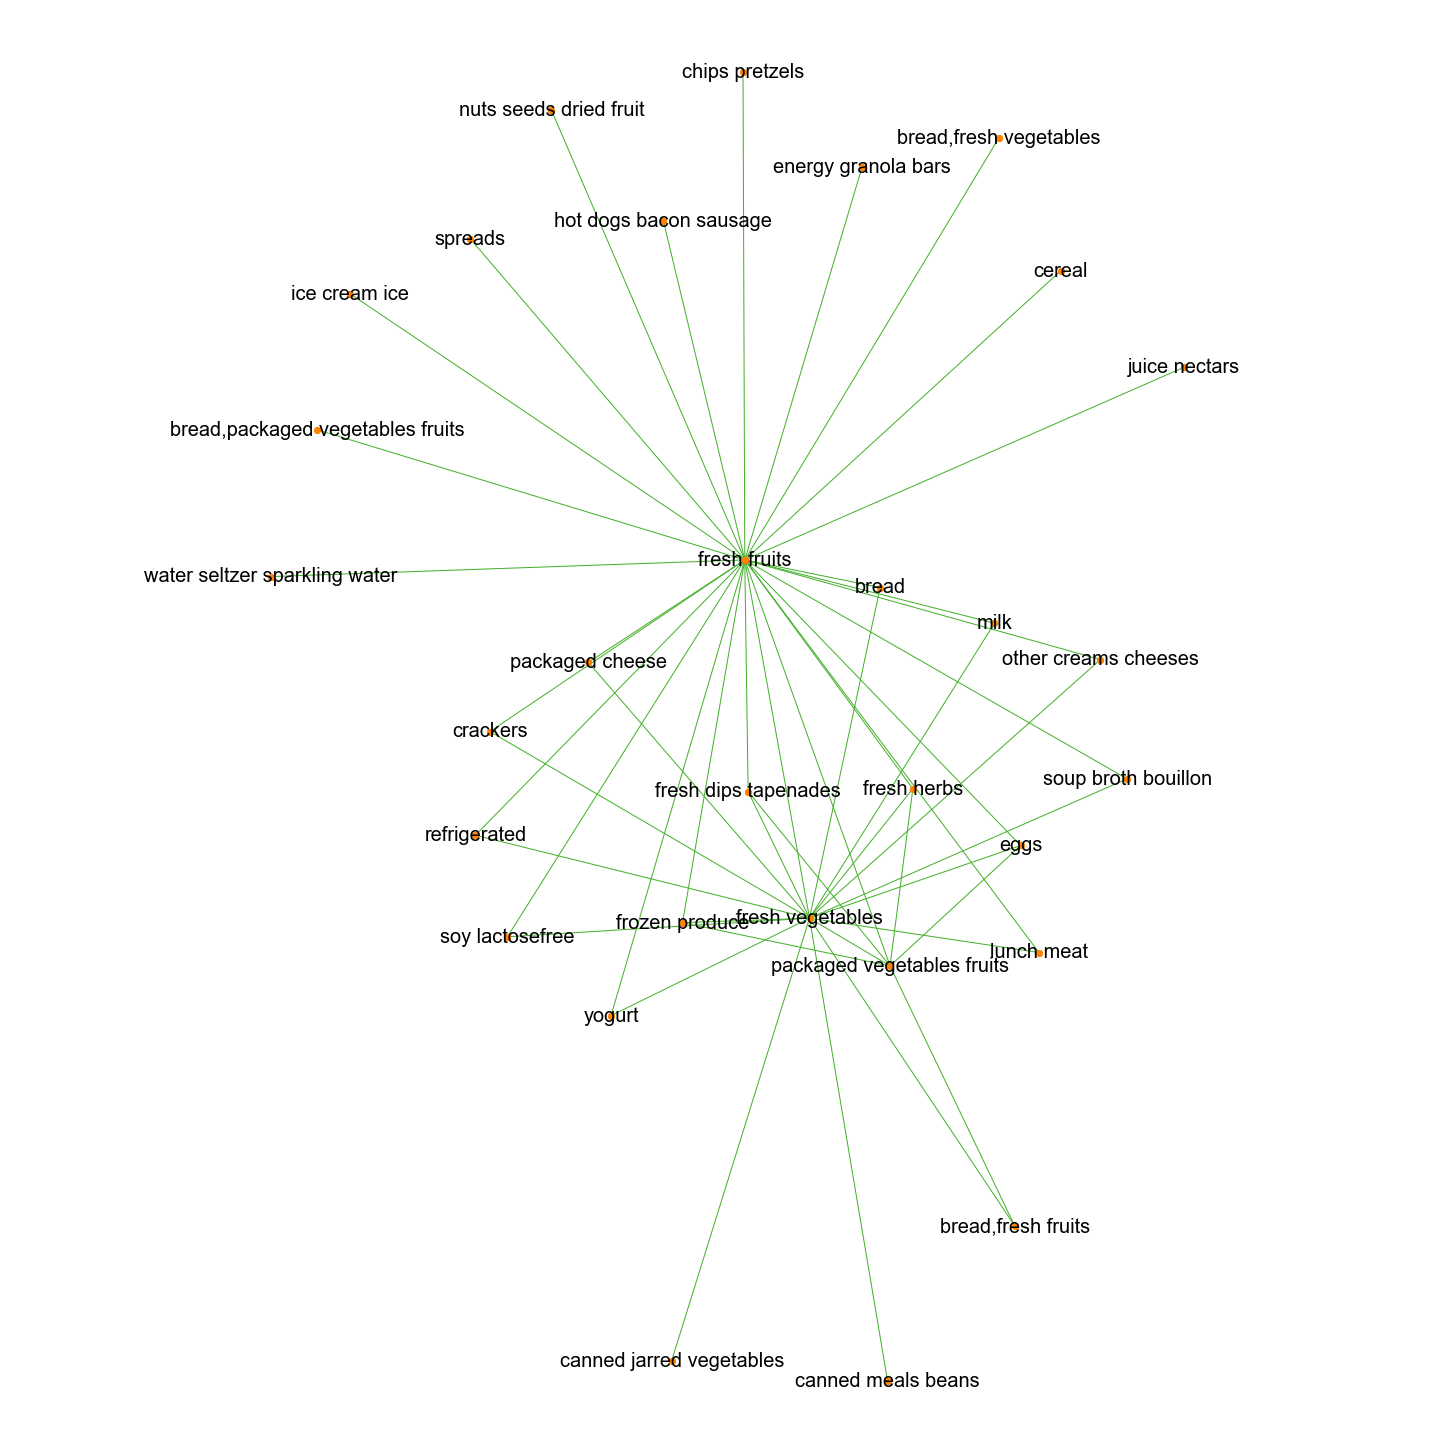

In [112]:
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')

my_pos = nx.spring_layout(G, seed = 1) #for reproducibility 
nx.draw(G, pos=my_pos, with_labels=True, edge_color = '#43b02a', node_size=40, node_color="#ff8200", font_color = 'black', font_size=20)
plt.axis('equal')
plt.show()

## 5.4 Top 15 add to order 

In [113]:
atco = user_order_products_all_details[user_order_products_all_details['add_to_cart_order'] <= 15]
atco = pd.merge(atco,departments, how='left',on='department_id')
grouped = atco.groupby("department")["order_id"].agg( Total_orders = 'count').reset_index()
grouped['Ratio'] = round(grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())*100,2)
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped.reset_index(drop=True)[:10]

department  Total_orders  Ratio
0          produce        515312  29.69
1       dairy eggs        298915  17.22
2        beverages        151410   8.72
3           snacks        150196   8.65
4           frozen        116891   6.73
5           pantry         94150   5.42
6           bakery         63619   3.67
7             deli         55556   3.20
8     canned goods         53357   3.07
9  dry goods pasta         42978   2.48

In [114]:
atco = atco[['order_id','product_name']]

In [115]:
# Define dataset to machine learning
market_basket_atco = pd.pivot_table(atco, index='order_id', columns='product_name',aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

market_basket_atco.head()

product_name  air fresheners candles  asian foods  baby accessories  \
order_id                                                              
10                               0.0          0.0               0.0   
11                               0.0          0.0               0.0   
28                               0.0          0.0               0.0   
38                               0.0          0.0               0.0   
56                               0.0          0.0               0.0   

product_name  baby bath body care  baby food formula  bakery desserts  \
order_id                                                                
10                            0.0                1.0              0.0   
11                            0.0                0.0              0.0   
28                            0.0                0.0              0.0   
38                            0.0                0.0              0.0   
56                            0.0                0.0              0.0   

product_name  baking ingredients  baking supplies decor  beauty  \
order_id                                                          
10                           0.0                    0.0     0.0   
11                           0.0                    0.0     0.0   
28                           0.0                    0.0     0.0   
38                           0.0                    0.0     0.0   
56                           0.0                    0.0     0.0   

product_name  beers coolers  ...  spreads  tea  tofu meat alternatives  \
order_id                     ...                                         
10                      0.0  ...      0.0  0.0                     0.0   
11                      0.0  ...      0.0  0.0                     0.0   
28                      0.0  ...      1.0  0.0                     0.0   
38                      0.0  ...      0.0  0.0                     0.0   
56                      0.0  ...      0.0  0.0                     0.0   

product_name  tortillas flat bread  trail mix snack mix  trash bags liners  \
order_id                                                                     
10                             0.0                  0.0                0.0   
11                             0.0                  0.0                0.0   
28                             0.0                  0.0                0.0   
38                             0.0                  0.0                0.0   
56                             0.0                  0.0                0.0   

product_name  vitamins supplements  water seltzer sparkling water  \
order_id                                                            
10                             0.0                            0.0   
11                             0.0                            0.0   
28                             0.0                            0.0   
38                             0.0                            0.0   
56                             0.0                            0.0   

product_name  white wines  yogurt  
order_id                           
10                    0.0     0.0  
11                    0.0     0.0  
28                    0.0     1.0  
38                    0.0     0.0  
56                    0.0     0.0  

[5 rows x 134 columns]

In [116]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 2%

itemsets = apriori(market_basket_first, min_support= 0.05, use_colnames=True)

In [117]:
# Build your association rules using the mxltend association_rules function.
# min_threshold can be thought of as the level of confidence percentage that you want to return
# Defined to use 50% of min_threshold

rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [118]:
# Below the list of products sales combinations
# It can use this information to build a cross-sell recommendation system that promotes these products with each other 

rules.sort_values("lift", ascending = False, inplace = True)
rules.head(10)

antecedents  \
192               (fresh fruits, fresh vegetables)   
197                                  (fresh herbs)   
195                             (fresh vegetables)   
194                    (fresh fruits, fresh herbs)   
374     (packaged vegetables fruits, fresh fruits)   
379                     (yogurt, fresh vegetables)   
360  (packaged cheese, packaged vegetables fruits)   
365               (fresh fruits, fresh vegetables)   
363     (packaged vegetables fruits, fresh fruits)   
362            (packaged cheese, fresh vegetables)   

                                       consequents  antecedent support  \
192                                  (fresh herbs)            0.312551   
197               (fresh fruits, fresh vegetables)            0.095724   
195                    (fresh fruits, fresh herbs)            0.448915   
194                             (fresh vegetables)            0.069855   
374                     (yogurt, fresh vegetables)            0.261384   
379     (packaged vegetables fruits, fresh fruits)            0.146320   
360               (fresh fruits, fresh vegetables)            0.114085   
365  (packaged cheese, packaged vegetables fruits)            0.312551   
363            (packaged cheese, fresh vegetables)            0.261384   
362     (packaged vegetables fruits, fresh fruits)            0.136690   

     consequent support   support  confidence      lift  leverage  conviction  
192            0.095724  0.063163    0.202089  2.111164  0.033244    1.133304  
197            0.312551  0.063163    0.659847  2.111164  0.033244    2.020997  
195            0.069855  0.063163    0.140702  2.014204  0.031804    1.082447  
194            0.448915  0.063163    0.904206  2.014204  0.031804    5.752794  
374            0.146320  0.074588    0.285357  1.950235  0.036342    1.194556  
379            0.261384  0.074588    0.509760  1.950235  0.036342    1.506642  
360            0.312551  0.068386    0.599428  1.917856  0.032728    1.716167  
365            0.114085  0.068386    0.218799  1.917856  0.032728    1.134042  
363            0.136690  0.068386    0.261630  1.914036  0.032657    1.169210  
362            0.261384  0.068386    0.500299  1.914036  0.032657    1.478114

In [119]:
top_rules = rules.sort_values('confidence', ascending = False)[:10]
top_rules

antecedents         consequents  \
194                        (fresh fruits, fresh herbs)  (fresh vegetables)   
85                                       (fresh herbs)  (fresh vegetables)   
372  (packaged vegetables fruits, yogurt, fresh veg...      (fresh fruits)   
343  (milk, packaged vegetables fruits, fresh veget...      (fresh fruits)   
282      (soy lactosefree, packaged vegetables fruits)      (fresh fruits)   
357  (packaged cheese, packaged vegetables fruits, ...      (fresh fruits)   
247       (packaged vegetables fruits, frozen produce)      (fresh fruits)   
242                         (yogurt, fresh vegetables)      (fresh fruits)   
187           (fresh dips tapenades, fresh vegetables)      (fresh fruits)   
229                (soy lactosefree, fresh vegetables)      (fresh fruits)   

     antecedent support  consequent support   support  confidence      lift  \
194            0.069855            0.448915  0.063163    0.904206  2.014204   
85             0.095724            0.448915  0.081688    0.853367  1.900957   
372            0.087890            0.531582  0.074588    0.848654  1.596469   
343            0.065938            0.531582  0.055329    0.839109  1.578514   
282            0.076954            0.531582  0.063163    0.820785  1.544043   
357            0.083565            0.531582  0.068386    0.818359  1.539480   
247            0.070181            0.531582  0.056553    0.805814  1.515880   
242            0.146320            0.531582  0.117349    0.802008  1.508720   
187            0.063245            0.531582  0.050433    0.797419  1.500089   
229            0.093031            0.531582  0.074180    0.797368  1.499993   

     leverage  conviction  
194  0.031804    5.752794  
85   0.038716    3.758274  
372  0.027867    3.095010  
343  0.020278    2.911401  
282  0.022255    2.613720  
357  0.023964    2.578820  
247  0.019246    2.412215  
242  0.039569    2.365843  
187  0.016813    2.312257  
229  0.024726    2.311676

In [120]:
frequent_itemsets=itemsets.copy()

In [121]:
# Reference this cell

### Rules are in the form of "frozensets". Frozensets have functions to check if there are subsets, supersets, etc.
### More info at https://www.journaldev.com/22850/python-frozenset

##### EXPLORE FREQUENT_ITEMSETS #####

# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Length=2 and Support>=0.2
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.1)]

support                                        itemsets  length
49   0.112045                           (bread, fresh fruits)       2
58   0.105517                  (fresh fruits, chips pretzels)       2
74   0.312551                (fresh fruits, fresh vegetables)       2
80   0.143300                            (milk, fresh fruits)       2
83   0.153991                 (packaged cheese, fresh fruits)       2
84   0.261384      (packaged vegetables fruits, fresh fruits)       2
87   0.109515                 (soy lactosefree, fresh fruits)       2
90   0.179615                          (fresh fruits, yogurt)       2
96   0.115636                        (milk, fresh vegetables)       2
98   0.136690             (packaged cheese, fresh vegetables)       2
99   0.237473  (packaged vegetables fruits, fresh vegetables)       2
104  0.146320                      (yogurt, fresh vegetables)       2
110  0.114085   (packaged cheese, packaged vegetables fruits)       2
115  0.126979            (packaged vegetables fruits, yogurt)       2

In [122]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)

### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]

# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

rulesToPlot

antecedents  \
0                                              (bread)   
1                                              (bread)   
2                           (canned jarred vegetables)   
3                                 (canned meals beans)   
4                                             (cereal)   
..                                                 ...   
123  (packaged vegetables fruits, fresh fruits, yog...   
124  (packaged vegetables fruits, yogurt, fresh veg...   
125           (fresh fruits, fresh vegetables, yogurt)   
126               (packaged vegetables fruits, yogurt)   
127                         (yogurt, fresh vegetables)   

                                    consequents  antecedent support  \
0                                (fresh fruits)            0.166395   
1                            (fresh vegetables)            0.166395   
2                            (fresh vegetables)            0.074017   
3                            (fresh vegetables)            0.070508   
4                                (fresh fruits)            0.102416   
..                                          ...                 ...   
123                          (fresh vegetables)            0.101191   
124                              (fresh fruits)            0.087890   
125                (packaged vegetables fruits)            0.117349   
126            (fresh fruits, fresh vegetables)            0.126979   
127  (packaged vegetables fruits, fresh fruits)            0.146320   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.531582  0.112045    0.673369  1.266728  0.023593    1.434092   
1              0.448915  0.092296    0.554684  1.235611  0.017599    1.237514   
2              0.448915  0.056798    0.767365  1.709378  0.023571    2.368884   
3              0.448915  0.050596    0.717593  1.598506  0.018944    1.951384   
4              0.531582  0.062837    0.613546  1.154190  0.008394    1.212093   
..                  ...       ...         ...       ...       ...         ...   
123            0.448915  0.074588    0.737097  1.641953  0.029162    2.096153   
124            0.531582  0.074588    0.848654  1.596469  0.027867    3.095010   
125            0.360372  0.074588    0.635605  1.763746  0.032298    1.755315   
126            0.312551  0.074588    0.587404  1.879385  0.034900    1.666154   
127            0.261384  0.074588    0.509760  1.950235  0.036342    1.506642   

                                                   LHS  \
0                                                bread   
1                                                bread   
2                             canned jarred vegetables   
3                                   canned meals beans   
4                                               cereal   
..                                                 ...   
123     packaged vegetables fruits,fresh fruits,yogurt   
124  packaged vegetables fruits,yogurt,fresh vegeta...   
125               fresh fruits,fresh vegetables,yogurt   
126                  packaged vegetables fruits,yogurt   
127                            yogurt,fresh vegetables   

                                         RHS  \
0                               fresh fruits   
1                           fresh vegetables   
2                           fresh vegetables   
3                           fresh vegetables   
4                               fresh fruits   
..                                       ...   
123                         fresh vegetables   
124                             fresh fruits   
125               packaged vegetables fruits   
126            fresh fruits,fresh vegetables   
127  packaged vegetables fruits,fresh fruits   

                                             sortedRow  
0                            ['bread', 'fresh fruits']  
1                        ['bread', 'fresh vegetables']  
2     ['canned jarred vegetables', 'fresh vegetables']  
3           ['cann

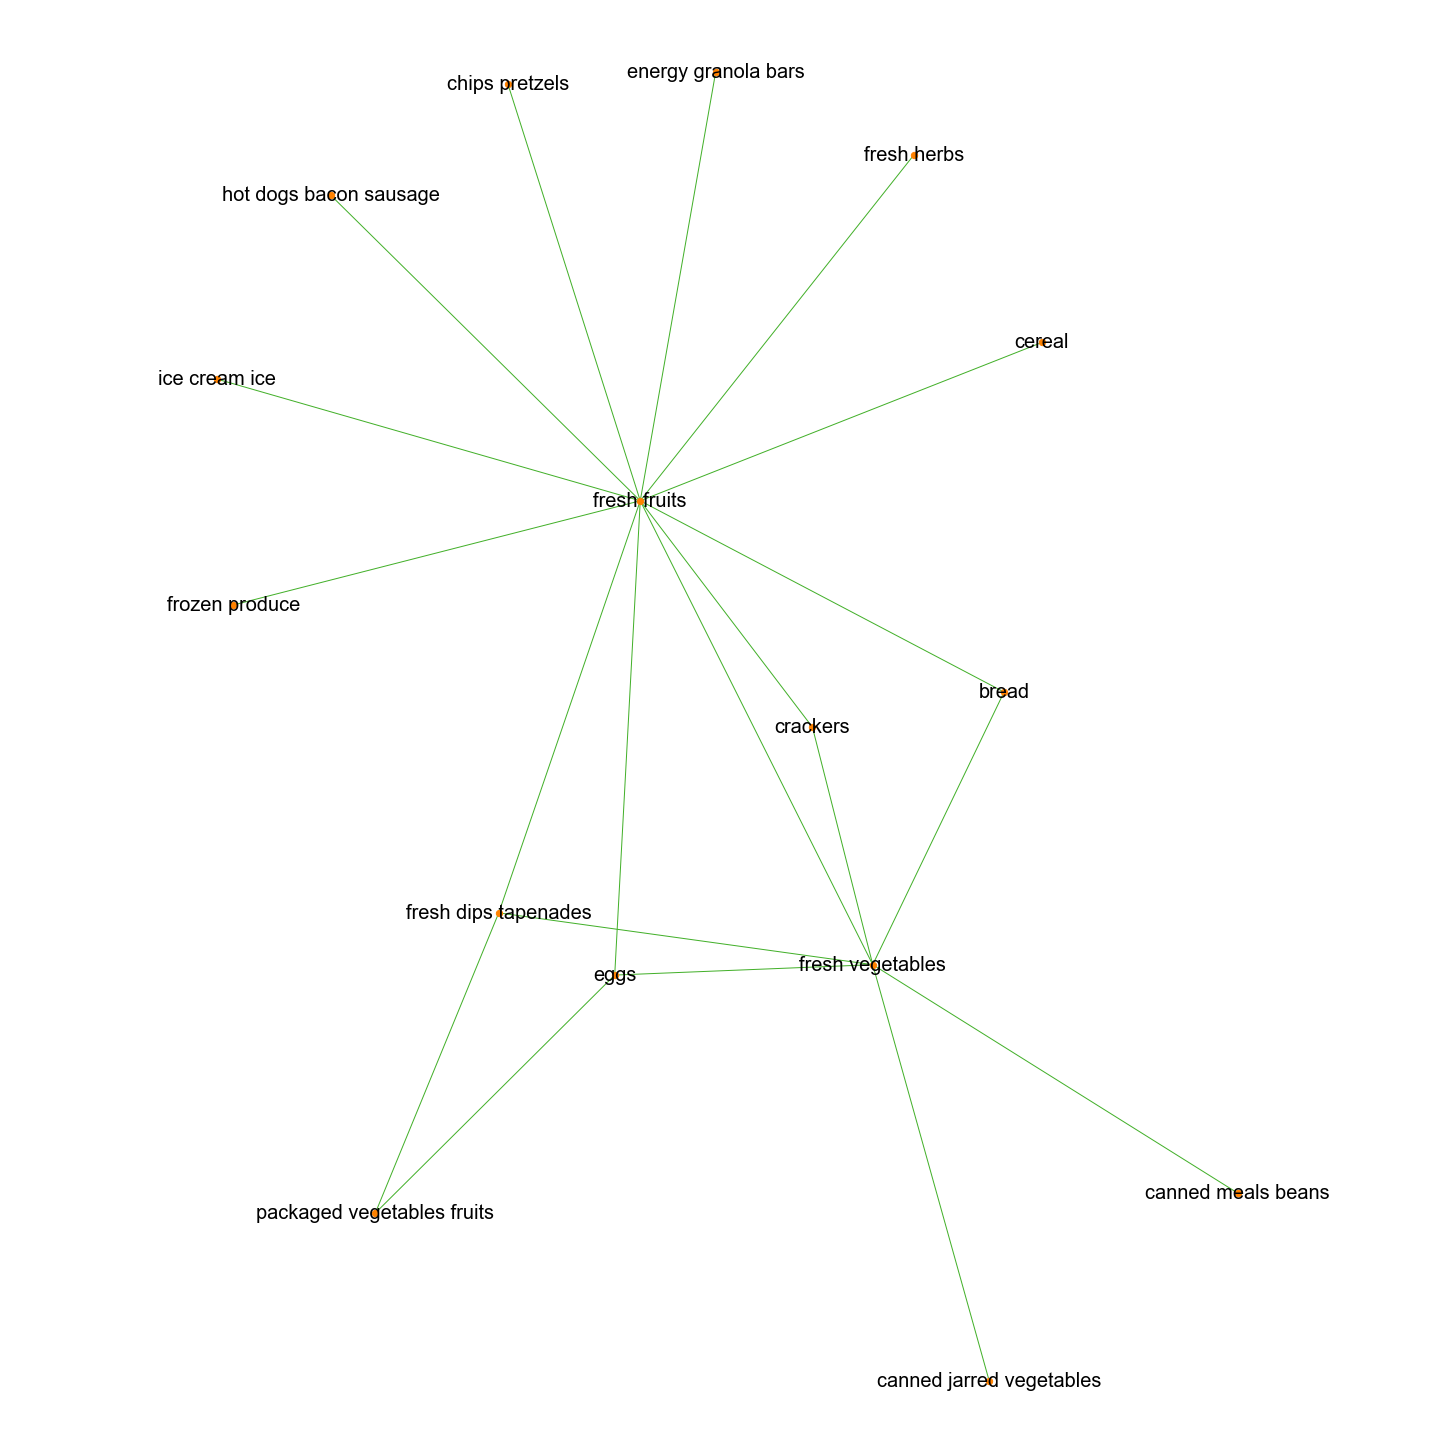

In [123]:
# Plot
rulesToPlot=rulesToPlot[:20]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')

my_pos = nx.spring_layout(G, seed = 1) #for reproducibility 
nx.draw(G, pos=my_pos, with_labels=True, edge_color = '#43b02a', node_size=40, node_color="#ff8200", font_color = 'black', font_size=20)
plt.axis('equal')
plt.show()

# 6. Analysis per Day of Week <a class="anchor" id="6"></a>

limitation:

days since prior order = 0...means the individual ordered twice in the same day. 
Could we consider this as one basket? The individual forgot to order other items needed?
We can't explore this because we only have a sample, don't have the data for the earlier order made that day.


## 6.1 Feature Engineering

In [124]:
data2 = pd.merge(user_order_products_all_details, departments, on='department_id')

### 6.1.1 tofd (time of the day)

In [125]:
# We plan to conduct the days of the week analysis then hours of the day. However, instead of hours of the day we 
# tranform it to 4 categorical values--times of the day: 
# Morning (6 to 11, since 11:59 is still stamped as hour 11), Afternoon (12 to 16), evening (17 to 20), night (21 to 5).
# The exact hours of the times of the day is subjective and seasonaly changing. We will stick to the above for simplicity.

print(sum((data2['order_hour_of_day']>=6) & (data2['order_hour_of_day']<12)))
print(sum((data2['order_hour_of_day']>=12) & (data2['order_hour_of_day']<17))) 
print(sum((data2['order_hour_of_day']>=17) & (data2['order_hour_of_day']<21)))

# night:
print(sum(data2['order_hour_of_day']>=21))
print(sum(data2['order_hour_of_day']<6))
print((sum(data2['order_hour_of_day']>=21))+(sum(data2['order_hour_of_day']<6)))

673035
823122
372425
113950
36969
150919


In [126]:
#Morning = 0, Afternoon = 1, Evening = 2, Night = 3
# tofd = time of the day
data2['tofd'] = data2['order_hour_of_day']

data2.loc[(data2['order_hour_of_day']>=6) & (data2['order_hour_of_day']<12), 'tofd'] = 0
data2.loc[(data2['order_hour_of_day']>=12) & (data2['order_hour_of_day']<17), 'tofd'] = 1
data2.loc[(data2['order_hour_of_day']>=17) & (data2['order_hour_of_day']<21), 'tofd'] = 2

# night
data2.loc[data2['order_hour_of_day']>=21, 'tofd'] = 3
data2.loc[data2['order_hour_of_day']<6, 'tofd'] = 3

In [127]:
#Check
print(sum(data2['tofd']==0))
print(sum(data2['tofd']==1))
print(sum(data2['tofd']==2))
print(sum(data2['tofd']==3))

673035
823122
372425
150919


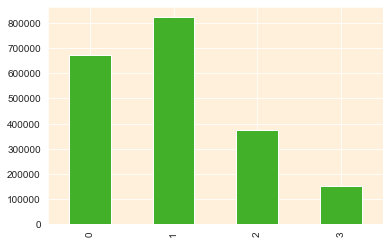

In [128]:
data2['tofd'].value_counts(sort=False).plot(kind='bar', color = '#43b02a')
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

## 6.2 Data Split

### 6.2.1 Split by the days of the week.

In [129]:
# Data split per dow, saved in a list.
dow_range = [0,1,2,3,4,5,6]
df_dow_list=[]

for i in dow_range:
    df_input = data2[(data2['order_dow']==i)]
    df_dow_list.append(df_input)

Day index from the list.<br>

0 = Sun<br>
1 = Mon<br>
2 = Tue<br>
3 = Wed<br>
4 = Thu<br>
5 = Fri<br>
6 = Sat<br>

In [130]:
#example to retrieve Sunday data
df_dow_list[0]

order_id  user_id  order_number  order_dow  order_hour_of_day  \
9         2772240    82371            23          0                  8   
13         325441    47716             5          0                 16   
24        2749827   104844            27          0                 14   
25        2749827   104844            27          0                 14   
28        2101376   171617             9          0                  9   
...           ...      ...           ...        ...                ...   
2019482   3396980    14573             4          0                 16   
2019486     91813   195573            63          0                 21   
2019488   2816975    48477             1          0                 17   
2019493   2684142    62337            11          0                 15   
2019497   1709950    73422            10          0                 14   

         days_since_prior_order  product_id  add_to_cart_order  reordered  \
9                           7.0          51                  3          1   
13                         30.0          29                 11          0   
24                          7.0         104                  1          1   
25                          7.0          72                 15          0   
28                          1.0          51                  9          0   
...                         ...         ...                ...        ...   
2019482                     6.0           6                  2          0   
2019486                     3.0           6                  4          1   
2019488                     NaN           6                  5          0   
2019493                     9.0           6                  3          0   
2019497                     2.0           6                  3          0   

         department_id            product_name department  tofd  
9                   13  preserved dips spreads     pantry     0  
13                  13   honeys syrups nectars     pantry     1  
24                  13       spices seasonings     pantry     1  
25                  13              condiments     pantry     1  
28                  13  preserved dips spreads     pantry     0  
...                ...                     ...        ...   ...  
2019482              2                   other      other     1  
2019486              2                   other      other     3  
2019488              2                   other      other     2  
2019493              2                   other      other     1  
2019497              2                   other      other     1  

[391831 rows x 13 columns]

### 6.2.2 Data Split per dow per tofd

In [131]:
# Data split per dow (days of the week) per tofd (time of the day), saved in a list.
dow_range = [0,1,2,3,4,5,6]
tofd_range = [0,1,2,3]
df_tofd_list=[]

for i in dow_range:
    for j in tofd_range:
        df_input = data2[(data2['order_dow']==i) & (data2['tofd']==j)]
        df_tofd_list.append(df_input)

In [132]:
df_tofd_list[0]

order_id  user_id  order_number  order_dow  order_hour_of_day  \
9         2772240    82371            23          0                  8   
28        2101376   171617             9          0                  9   
29        2101376   171617             9          0                  9   
30        2101376   171617             9          0                  9   
31        2101376   171617             9          0                  9   
...           ...      ...           ...        ...                ...   
2019419    334536   173675            11          0                 11   
2019434   3008454   186970            39          0                  9   
2019449   3407232    36753            17          0                  9   
2019455   1527852   182537             8          0                  8   
2019478   1380913    32889            40          0                  8   

         days_since_prior_order  product_id  add_to_cart_order  reordered  \
9                           7.0          51                  3          1   
28                          1.0          51                  9          0   
29                          1.0          17                 10          0   
30                          1.0          17                 11          0   
31                          1.0          17                 13          0   
...                         ...         ...                ...        ...   
2019419                    30.0           6                 23          0   
2019434                     7.0           6                  3          0   
2019449                     3.0           6                 11          0   
2019455                     1.0           6                  9          1   
2019478                     8.0           6                  7          1   

         department_id            product_name department  tofd  
9                   13  preserved dips spreads     pantry     0  
28                  13  preserved dips spreads     pantry     0  
29                  13      baking ingredients     pantry     0  
30                  13      baking ingredients     pantry     0  
31                  13      baking ingredients     pantry     0  
...                ...                     ...        ...   ...  
2019419              2                   other      other     0  
2019434              2                   other      other     0  
2019449              2                   other      other     0  
2019455              2                   other      other     0  
2019478              2                   other      other     0  

[123876 rows x 13 columns]

The dfs_list can be accessed:

Day range: 0 = Sunday...6 = Monday<br>
Time range: 0 = Morning...3 = Night

Day : Time<br>
0 : 0 = df_tofd_list\[0\]<br>
0 : 1 = df_tofd_list\[1\]<br>
0 : 2 = df_tofd_list\[2\]<br>
0 : 3 = df_tofd_list\[3\]<br>

1 : 0 = df_tofd_list\[4\]<br>
1 : 1 = df_tofd_list\[5\]<br>
1 : 2 = df_tofd_list\[6\]<br>
1 : 3 = df_tofd_list\[7\]<br>
...(continues)...<br>
6 : 3 = df_tofd_list\[27\]<br>

Notice the multiples of 4 is a new day<br>
For easier reference:<br>
0 = Sun<br>
4 = Mon<br>
8 = Tue<br>
12 = Wed<br>
16 = Thu<br>
20 = Fri<br>
24 = Sat<br>

In [133]:
df_output = pd.DataFrame()
for i in range(len(df_tofd_list)):
    df_output = df_output.append(pd.DataFrame([i,len(df_tofd_list[i])]).T)
#     print('Index {}: {}'.format(i,len(df_tofd_list[i])))
df_output.reset_index(inplace=True,drop=True)

In [134]:
df_output

0       1
0    0  123876
1    1  171971
2    2   67392
3    3   28592
4    4  129591
5    5  137957
6    6   59382
7    7   22306
8    8   87562
9    9  103813
10  10   51077
11  11   19460
12  12   77609
13  13   96083
14  14   46722
15  15   18316
16  16   74338
17  17   91827
18  18   48189
19  19   20530
20  20   89662
21  21  104468
22  22   48585
23  23   19442
24  24   90397
25  25  117003
26  26   51078
27  27   22273

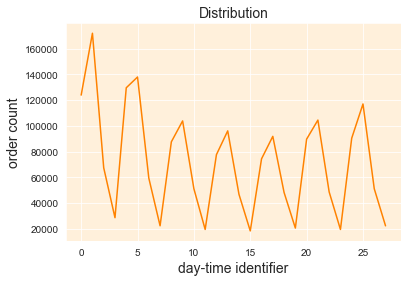

In [135]:
# plotting frequency of orders over day and time (i.e. morning, afternoon, evening, night)
# example: 3 is Sunday night 
plt.plot(df_output[0], df_output[1], color='#ff8200')
plt.title('Distribution',fontsize=14)
plt.xlabel('day-time identifier',fontsize=14)
plt.ylabel('order count',fontsize=14)
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
ax = plt.gca()
ax.set_facecolor('#fff0db')
plt.show()

## 6.3 Apriori, Confidence, Lift Analysis

In [136]:
# dfl = list of data frames (e.g., df_tofd_list)

# ms = apriori min_support value, 0.05 by default
# cmt = confidence min_threshold, 0.5 by default
# lmt = lift min_threshold, 1.5 by default

# cmptc = complement: min_threshold for confidence
# cmptl = complement: min_threshold for lift
# cmptl_c = complement: ceiling for lift (e.g, cmptl_c=1.5, max lift value is 1.5)
#subsmt = substitutes: min_threshold for lift
def ACL_per_split(dfl, ms=0.05, cmt=0.50, lmt=1.5, cmptc=0.8, cmptl=1.8, cmptl_c=99, subsmt=0.0):
    cmptl_c=cmptl_c
    filtdf_list=[]
    pivot_list=[]
    apriori_list=[]
    rConf_list=[] # List of association dfs by confidence
    rLift_list=[] # List of association dfs by lift
    cmpt_list=[] # List of potential complements dfs
    subs_list=[] # List of potential subs dfs
    for i in range(len(dfl)):
        df_input = dfl[i][['order_id','product_name']]
        filtdf_list.append(df_input)
        # Pivot the data - lines as orders and products as columns
        pt_input = pd.pivot_table(df_input, index='order_id', columns='product_name', 
                            aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
        pivot_list.append(pt_input)
        # Apriori
        freq_sets_input = apriori(pt_input, min_support=ms, use_colnames=True)
        apriori_list.append(freq_sets_input)
        # Association - by confidence
        rConf_input = association_rules(freq_sets_input, metric="confidence", min_threshold=cmt)
        rConf_input.sort_values(by='confidence', ascending=False, inplace=True)
        rConf_list.append(rConf_input)
        # Association - by lift
        rLift_input = association_rules(freq_sets_input, metric="lift", min_threshold=lmt)
        rLift_input.sort_values(by='lift', ascending=False, inplace=True)
        rLift_list.append(rLift_input)
        # High confidence and high lift - complementary products
        if cmptl_c != 99:
            cmpt_input = rConf_input[(rConf_input['confidence']>=cmptc)&(rConf_input['lift']>=cmptl)&(rConf_input['lift']<=cmptl_c)]
        else:
            cmpt_input = rConf_input[(rConf_input['confidence']>=cmptc)&(rConf_input['lift']>=cmptl)]
        cmpt_list.append(cmpt_input)
        # Subtitute products
        subs_input = association_rules(freq_sets_input, metric = 'lift',min_threshold=subsmt)
        subs_input.sort_values(by='lift', ascending=True, inplace=True)
        subs_list.append(subs_input)
    return rConf_list, rLift_list, cmpt_list, subs_list

### 6.3.1 DOW Result

In [137]:
pd.options.display.max_rows = 200 # 200 max rows for data inspection

In [138]:
rConf_list_dow, rLift_list_dow, cmpt_list_dow, subs_list_dow = ACL_per_split(df_dow_list)

In [139]:
df_subs_dow = pd.DataFrame()
for i in range(0,len(subs_list_dow)):
    df_insert = subs_list_dow[i].iloc[:5,:][["antecedents","consequents","lift"]]
    df_insert["index"] = i
    df_subs_dow = df_subs_dow.append(df_insert)
df_subs_dow

antecedents                       consequents  \
172   (water seltzer sparkling water)                (fresh vegetables)   
173                (fresh vegetables)   (water seltzer sparkling water)   
36                           (cereal)                (fresh vegetables)   
37                 (fresh vegetables)                          (cereal)   
147                (fresh vegetables)                   (ice cream ice)   
109                (fresh vegetables)   (water seltzer sparkling water)   
108   (water seltzer sparkling water)                (fresh vegetables)   
238  (fresh fruits, fresh vegetables)   (water seltzer sparkling water)   
243   (water seltzer sparkling water)  (fresh fruits, fresh vegetables)   
133   (water seltzer sparkling water)      (packaged vegetables fruits)   
90    (water seltzer sparkling water)                (fresh vegetables)   
91                 (fresh vegetables)   (water seltzer sparkling water)   
189   (water seltzer sparkling water)  (fresh fruits, fresh vegetables)   
184  (fresh fruits, fresh vegetables)   (water seltzer sparkling water)   
110      (packaged vegetables fruits)   (water seltzer sparkling water)   
85                 (fresh vegetables)   (water seltzer sparkling water)   
84    (water seltzer sparkling water)                (fresh vegetables)   
65    (water seltzer sparkling water)                    (fresh fruits)   
64                     (fresh fruits)   (water seltzer sparkling water)   
170  (fresh fruits, fresh vegetables)   (water seltzer sparkling water)   
85                 (fresh vegetables)   (water seltzer sparkling water)   
84    (water seltzer sparkling water)                (fresh vegetables)   
183   (water seltzer sparkling water)  (fresh fruits, fresh vegetables)   
178  (fresh fruits, fresh vegetables)   (water seltzer sparkling water)   
66                     (fresh fruits)   (water seltzer sparkling water)   
97                 (fresh vegetables)   (water seltzer sparkling water)   
96    (water seltzer sparkling water)                (fresh vegetables)   
116      (packaged vegetables fruits)   (water seltzer sparkling water)   
117   (water seltzer sparkling water)      (packaged vegetables fruits)   
196  (fresh fruits, fresh vegetables)   (water seltzer sparkling water)   
123                (fresh vegetables)                   (ice cream ice)   
122                   (ice cream ice)                (fresh vegetables)   
142   (water seltzer sparkling water)                (fresh vegetables)   
143                (fresh vegetables)   (water seltzer sparkling water)   
86                    (ice cream ice)                    (fresh fruits)   

         lift  index  
172  1.001696      0  
173  1.001696      0  
36   1.003836      0  
37   1.003836      0  
147  1.003870      0  
109  0.949087      1  
108  0.949087      1  
238  1.007130      1  
243  1.007130      1  
133  1.011725      1  
90   0.961079      2  
91   0.961079      2  
189  1.027428      2  
184  1.027428      2  
110  1.029172      2  
85   0.945355      3  
84   0.945355      3  
65   1.003114      3  
64   1.003114      3  
170  1.019049      3  
85   0.963209      4  
84   0.963209      4  
183  1.036892      4  
178  1.036892      4  
66   1.037896      4  
97   0.972161      5  
96   0.972161      5  
116  1.041015      5  
117  1.041015      5  
196  1.041153      5  
123  0.990400      6  
122  0.990400      6  
142  0.997933      6  
143  0.997933      6  
86   1.034761      6

 lift values higher than 1 in many cases. This is not a problem per se, since people still buy substitutes together<br>
 (e.g. pretzels can be a substitute for mini carrots, but you still buy them together often...even more so in this case because "fresh vegetables" include such a wide range of products)<br>
 But still, need to play with different parameters for ACL_per_split(), especially the ms value,<br> 
 and maybe a restriction on max lift value.

In [140]:
df_cmpt_dow = pd.DataFrame()
for i in range(0,len(cmpt_list_dow)):
    df_insert = cmpt_list_dow[i].iloc[:5,:][["antecedents","consequents","lift"]]
    df_insert["index"] = i
    df_cmpt_dow = df_cmpt_dow.append(df_insert)
df_cmpt_dow

antecedents         consequents      lift  \
66                 (fresh fruits, fresh herbs)  (fresh vegetables)  2.025758   
33                               (fresh herbs)  (fresh vegetables)  1.951179   
48                 (fresh fruits, fresh herbs)  (fresh vegetables)  2.092095   
28                               (fresh herbs)  (fresh vegetables)  2.007477   
26                               (fresh herbs)  (fresh vegetables)  2.077131   
46                 (fresh fruits, fresh herbs)  (fresh vegetables)  2.180681   
27                               (fresh herbs)  (fresh vegetables)  2.082811   
52                 (fresh fruits, fresh herbs)  (fresh vegetables)  2.114490   
30                               (fresh herbs)  (fresh vegetables)  2.023854   
136  (packaged vegetables fruits, fresh herbs)  (fresh vegetables)  1.829883   
89                 (fresh fruits, fresh herbs)  (fresh vegetables)  1.804170   

     index  
66       1  
33       1  
48       2  
28       2  
26       3  
46       4  
27       4  
52       5  
30       5  
136      6  
89       6

In [141]:
rConf_list_dow2, rLift_list_dow2, cmpt_list_dow2, subs_list_dow2 = ACL_per_split(df_dow_list, ms=0.04)

In [142]:
df_subs_dow2 = pd.DataFrame()
for i in range(0,len(subs_list_dow2)):
    df_insert = subs_list_dow2[i].iloc[:20,:][["antecedents","consequents","lift"]]
    df_insert["index"] = i
    df_subs_dow2 = df_subs_dow2.append(df_insert)
df_subs_dow2.iloc[::2] #select even (or odd) number index value to exclude opposite direction duplicates. 

antecedents  \
266                                          (milk)   
188                              (fresh vegetables)   
268                                          (milk)   
228                 (water seltzer sparkling water)   
48                                         (cereal)   
195                              (fresh vegetables)   
619                                 (ice cream ice)   
142                                 (ice cream ice)   
197                                 (juice nectars)   
217                              (fresh vegetables)   
130                                  (fresh fruits)   
179                              (fresh vegetables)   
83                            (energy granola bars)   
63                               (fresh vegetables)   
550                 (water seltzer sparkling water)   
408                (fresh fruits, fresh vegetables)   
219                 (water seltzer sparkling water)   
23                                   (fresh fruits)   
139                 (water seltzer sparkling water)   
201                 (water seltzer sparkling water)   
149                              (fresh vegetables)   
164                                          (milk)   
434                 (water seltzer sparkling water)   
310                (fresh fruits, fresh vegetables)   
181                 (water seltzer sparkling water)   
117                 (water seltzer sparkling water)   
21                                   (fresh fruits)   
58                                          (cream)   
172                               (packaged cheese)   
93                                   (fresh fruits)   
121                              (fresh vegetables)   
132                                          (milk)   
93                  (water seltzer sparkling water)   
263                 (water seltzer sparkling water)   
146                    (packaged vegetables fruits)   
138                               (packaged cheese)   
103                              (fresh vegetables)   
318      (packaged vegetables fruits, fresh fruits)   
69                                   (fresh fruits)   
155                                        (yogurt)   
97                                    (soft drinks)   
135                              (fresh vegetables)   
148                                          (milk)   
287                 (water seltzer sparkling water)   
104                                  (fresh fruits)   
79                                   (fresh fruits)   
406                 (water seltzer sparkling water)   
164                    (packaged vegetables fruits)   
0                              (baking ingredients)   
342      (packaged vegetables fruits, fresh fruits)   
120                                  (fresh fruits)   
183                 (water seltzer sparkling water)   
163                              (fresh vegetables)   
485  (packaged vegetables fruits, fresh vegetables)   
199                 (water seltzer sparkling water)   
352                (fresh fruits, fresh vegetables)   
23                                   (fresh fruits)   
128                                  (fresh fruits)   
190                               (packaged cheese)   
99                                   (fresh fruits)   
146                                  (fresh fruits)   
165                                  (frozen meals)   
170                                 (ice cream ice)   
200                 (water seltzer sparkling water)   
234                                          (milk)   
42                                         (cereal)   
172                              (fresh vegetables)   
477                                 (ice cream ice)   
124                                 (ice cream ice)   
217                    (packaged vegetables fruits)   

                                        consequents      lift  index  
266                               (soy lactosefree)  0.872122  

In [143]:
df_cmpt_dow2 = pd.DataFrame()
for i in range(0,len(cmpt_list_dow2)):
    df_insert = cmpt_list_dow2[i].iloc[:10,:][["antecedents","consequents","lift",'confidence']]
    df_insert["index"] = i
    df_cmpt_dow2 = df_cmpt_dow2.append(df_insert)
df_cmpt_dow2

antecedents         consequents  \
156          (packaged vegetables fruits, fresh herbs)  (fresh vegetables)   
106                        (fresh fruits, fresh herbs)  (fresh vegetables)   
49                                       (fresh herbs)  (fresh vegetables)   
79            (fresh fruits, canned jarred vegetables)  (fresh vegetables)   
80                         (fresh fruits, fresh herbs)  (fresh vegetables)   
43                                       (fresh herbs)  (fresh vegetables)   
65                         (fresh fruits, fresh herbs)  (fresh vegetables)   
36                                       (fresh herbs)  (fresh vegetables)   
108          (packaged vegetables fruits, fresh herbs)  (fresh vegetables)   
72                         (fresh fruits, fresh herbs)  (fresh vegetables)   
37                                       (fresh herbs)  (fresh vegetables)   
130          (packaged vegetables fruits, fresh herbs)  (fresh vegetables)   
88                         (fresh fruits, fresh herbs)  (fresh vegetables)   
47                                       (fresh herbs)  (fresh vegetables)   
241  (packaged vegetables fruits, fresh fruits, fre...  (fresh vegetables)   
199          (packaged vegetables fruits, fresh herbs)  (fresh vegetables)   
140                        (fresh fruits, fresh herbs)  (fresh vegetables)   

         lift  confidence  index  
156  2.045175    0.895642      1  
106  2.025758    0.887139      1  
49   1.951179    0.854479      1  
79   1.935240    0.847498      1  
80   2.092095    0.867993      2  
43   2.007477    0.832885      2  
65   2.182209    0.871438      3  
36   2.077131    0.829477      3  
108  2.207027    0.876307      4  
72   2.180681    0.865846      4  
37   2.082811    0.826986      4  
130  2.150958    0.871091      5  
88   2.114490    0.856322      5  
47   2.023854    0.819616      5  
241  1.861373    0.917277      6  
199  1.829883    0.901759      6  
140  1.804170    0.889088      6

In [144]:
pd.options.display.max_rows = 30 

Consideration:
- Complementary products are dominated by vegetables, fresh fruits, fresh herbs regardless of the parameters. Their complementarity makes sense, but they are also highly popular products. 
- file:///C:/Users/Lenovo/Desktop/NOVA/S2/Business%20Cases/BC3/jtaer-16-00039-v2.pdf maybe

### 6.3.2 TOFD per DOW Results

In [145]:
rConf_list_tofd, rLift_list_tofd, cmpt_list_tofd, subs_list_tofd = ACL_per_split(df_tofd_list)

In [146]:
df_subs_tofd = pd.DataFrame()
for i in range(0,len(subs_list_tofd)):
    df_insert = subs_list_tofd[i].iloc[:5,:][["antecedents","consequents","lift"]]
    df_insert["index"] = i
    df_subs_tofd = df_subs_tofd.append(df_insert)
df_subs_tofd

antecedents         consequents      lift  index
37                (fresh vegetables)            (cereal)  0.978064      0
36                          (cereal)  (fresh vegetables)  0.978064      0
148                  (ice cream ice)  (fresh vegetables)  0.993358      0
149               (fresh vegetables)     (ice cream ice)  0.993358      0
178  (water seltzer sparkling water)  (fresh vegetables)  1.018111      0
..                               ...                 ...       ...    ...
135               (fresh vegetables)     (ice cream ice)  0.904173     27
134                  (ice cream ice)  (fresh vegetables)  0.904173     27
137                  (juice nectars)  (fresh vegetables)  0.990035     27
136               (fresh vegetables)     (juice nectars)  0.990035     27
94                   (ice cream ice)      (fresh fruits)  1.030083     27

[140 rows x 4 columns]

In [147]:
df_cmpt_tofd = pd.DataFrame()
for i in range(0,len(cmpt_list_tofd)):
    df_insert = cmpt_list_tofd[i].iloc[:5,:][["antecedents","consequents","lift"]]
    df_insert["index"] = i
    df_cmpt_tofd = df_cmpt_tofd.append(df_insert)
df_cmpt_tofd

antecedents  \
251          (packaged vegetables fruits, fresh herbs)   
91                         (fresh fruits, fresh herbs)   
63                         (fresh fruits, fresh herbs)   
33                                       (fresh herbs)   
70                         (fresh fruits, fresh herbs)   
..                                                 ...   
180  (packaged vegetables fruits, fresh fruits, fre...   
150          (packaged vegetables fruits, fresh herbs)   
104                        (fresh fruits, fresh herbs)   
67                         (fresh fruits, fresh herbs)   
34                                       (fresh herbs)   

                          consequents      lift  index  
251  (fresh fruits, fresh vegetables)  1.994416      0  
91                 (fresh vegetables)  1.833504      2  
63                 (fresh vegetables)  2.196718      4  
33                 (fresh vegetables)  2.139521      4  
70                 (fresh vegetables)  1.915548      5  
..                                ...       ...    ...  
180                (fresh vegetables)  1.852250     24  
150                (fresh vegetables)  1.822543     24  
104                (fresh vegetables)  1.820905     24  
67                 (fresh vegetables)  1.937730     26  
34                 (fresh vegetables)  1.834945     26  

[46 rows x 4 columns]

In [148]:
# some days don't have products that meet the criteria for complements parameter, hence the index is missing for those.

In [149]:
mapping = pd.read_csv('Mapping.csv')

In [150]:
df = pd.merge(df_subs_tofd,mapping, how='left')
df1 = pd.merge(df_cmpt_tofd,mapping, how='left')

In [151]:
df = df[~(df.antecedents.str.len() > 1)]
df['antecedents'] = [list(x)[0] for x in df['antecedents']]
df['consequents'] = [list(x)[0] for x in df['consequents']]

In [152]:
df1.shape

(46, 6)

In [153]:
df1 = df1[~(df1.antecedents.str.len() > 1)]
df1['antecedents'] = [list(x)[0] for x in df1['antecedents']]
df1['consequents'] = [list(x)[0] for x in df1['consequents']]

In [154]:
fig = px.parallel_categories(df, dimensions=['Day', 'Time','antecedents','consequents'],
                color="lift", color_continuous_scale=px.colors.sequential.Inferno,
                labels={'Day':'Day', 'Time':'Time','antecedents':'antecedents','consequents':'consequents'})#'antecedents':'antecedents'})
fig.update_layout(legend = dict(bgcolor = '#fff0db'))
fig.show()

In [155]:
fig = px.parallel_categories(df, dimensions=['Day','antecedents','consequents'],
                color="lift", color_continuous_scale=px.colors.sequential.Inferno,
                labels={'Day':'Day', 'antecedents':'antecedents','consequents':'consequents'})#'antecedents':'antecedents'})
fig.show()

In [156]:
day_dim = go.parcats.Dimension(
    values=df1['Day'].values,
    categoryorder='category ascending', label="Day"
)

time_dim = go.parcats.Dimension(values=df1['Time'].values, label="Time")

a_dim = go.parcats.Dimension(
    values=df1['antecedents'].values, label="antecedents")

c_dim = go.parcats.Dimension(
    values=df1['consequents'].values, label="consequents")

# Create parcats trace
color = df1.lift
colorscale = [[0, 'lightsteelblue'], [1, 'mediumseagreen']]

fig = go.Figure(data = [go.Parcats(dimensions=[day_dim, time_dim, a_dim,c_dim],
        line={'color': color, 'colorscale': colorscale},
        hoveron='color', hoverinfo='count+probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.show()


# **7. Deployment** <a class="anchor" id="7"></a>

## 7.1 Shopping Cart Recommender

In [157]:
def Recommender_System(user_id):
    
    '''
    enter user_id and return a list of 5 recommendations.
    '''
    
    u = high_volume.groupby(['user_id','product_name']).size().sort_values(ascending=False).unstack().fillna(0)
    u_sim = pd.DataFrame(cosine_similarity(u), index=u.index, columns=u.index)

    p = high_volume.groupby(['product_name','user_id']).size().sort_values(ascending=False).unstack().fillna(0)
    
    recommendations = pd.Series(np.dot(p.values,cosine_dists[user_id]), index=p.index)
    return recommendations.sort_values(ascending=False).head()

In [158]:
# get the list of orders that have been reordered before
reorders = order_products[order_products['reordered'] == 1]
orders2 = orders[['order_id', 'user_id']]
reorders = pd.merge(reorders, products[['product_id', 'product_name']], how='left', on=['product_id'])
# merge to get user_id and product_id
user_orders = reorders.merge(orders2, on='order_id')
# filtering out the high volumn products that user reordered more than once
user_orders['high_volume'] = (user_orders['product_id'].value_counts().sort_values(ascending=False)>1)
high_volume = user_orders[user_orders['high_volume'] == True]
# get a matrix of different high volume items that particular user purchased
high_volume_users = high_volume.groupby(['user_id', 'product_name']).size().sort_values(ascending=False).unstack().fillna(0)
# calculate similarity between each user
cosine_dists = pd.DataFrame(cosine_similarity(high_volume_users),index=high_volume_users.index, columns=high_volume_users.index)
cosine_dists.head()

user_id    5430      30618     39332     41591     45892   52745   57561   \
user_id                                                                     
5430     1.000000  0.000000  0.223607  0.000000  0.149071     0.0     0.0   
30618    0.000000  1.000000  0.000000  0.188982  0.166667     0.0     0.0   
39332    0.223607  0.000000  1.000000  0.566947  0.333333     0.0     0.0   
41591    0.000000  0.188982  0.566947  1.000000  0.377964     0.0     0.0   
45892    0.149071  0.166667  0.333333  0.377964  1.000000     0.0     0.0   

user_id    62481     67155   81461   ...    100845    126892    135442  \
user_id                              ...                                 
5430     0.000000  0.158114     0.0  ...  0.258199  0.447214  0.000000   
30618    0.000000  0.000000     0.0  ...  0.000000  0.000000  0.277350   
39332    0.000000  0.000000     0.0  ...  0.000000  0.500000  0.416025   
41591    0.000000  0.267261     0.0  ...  0.000000  0.000000  0.524142   
45892    0.333333  0.000000     0.0  ...  0.000000  0.000000  0.462250   

user_id    143742    172653    178268    181484    189943    189954    190709  
user_id                                                                        
5430     0.000000  0.248069  0.000000  0.182574  0.000000  0.000000  0.200000  
30618    0.000000  0.277350  0.000000  0.000000  0.000000  0.500000  0.000000  
39332    0.000000  0.138675  0.500000  0.408248  0.353553  0.000000  0.000000  
41591    0.000000  0.419314  0.377964  0.308607  0.267261  0.251976  0.000000  
45892    0.149071  0.277350  0.333333  0.408248  0.000000  0.222222  0.149071  

[5 rows x 25 columns]

In [159]:
# recommendation for customer id=30618
Recommender_System(30618)

product_name
fresh fruits              6.656982
butter                    2.595445
yogurt                    1.668070
fresh vegetables          1.596343
hot dogs bacon sausage    1.547723
dtype: float64